# 0. Pleasantries

## 0.1. Installs

In [ ]:
!pip install matplotlib-venn --quiet
!pip install catboost --quiet
!pip install shap --quiet

     |████████████████████████████████| 76.8 MB 1.1 MB/s 
     |████████████████████████████████| 569 kB 14.0 MB/s 


## 0.2. Imports

In [ ]:
from collections import defaultdict
import json
import numpy as np
import os
import re
import pandas as pd
from pprint import pprint
import shutil
from tqdm.notebook import tqdm
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
import shap
# import load_boston
from matplotlib import pyplot as plt
# from sklearn.datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from collections import Counter


## 0.3. Set permissions

### 0.3.1. Google Cloud

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

### 0.3.2. Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Function Definitions

In [ ]:
NI = 'No info.'
SZ = 'Single Zero.'
SNZ = 'Single Non-zero.'
ZSNZ = 'Zero to Single Non-zero.'
ZMNZ = 'Zero to Multiple Non-zeros.'
MNZ = 'Multiple Non-zeros.'
DEFAULT_EVENT_DF_THRES = 5


ALL_NULLS = 'ALLNULL'
ALL_UNIQS = 'ALLUNIQ'
NN_ALL_UNIQS = 'NNALLUNIQ'
MOST_NULLS = 'MOSTNULL'
MOST_UNIQS = 'MOSTUNIQ'
NN_MOST_UNIQS = 'NNMOSTUNIQ'

MOST_NULL_PERC_THRES = 90
MOST_UNIQ_PERC_THRES = 80
NN_MOST_UNIQ_PERC_THRES = 90


CUST_KEEP_UNIQ_COLS = {'uid'}
CUST_DEL_COLS = {'en', 'upr:$joinTime', 'ecd',
                 'epr:$salesforce_lead_first_date_of_contact_to_qualified_c__c',
                 'epr:$salesforce_lead_first_date_of_contact_to_qualified_c__c'}
CUST_TIME_COLS = {'ujt', 'et', 'epr:$salesforce_lead_systemmodstamp', 'upr:$salesforce_lead_systemmodstamp'}
FORCED_CAT_COLS = {'epr:$salesforce_lead_round_robin_id__c', 'upr:$salesforce_lead_round_robin_id__c', 'epr:$salesforce_lead_is_designer_logged_in_for_report__c'}
FORCED_NUM_COLS = {'epr:$salesforce_lead_lead_number__c', 'upr:$salesforce_lead_lead_number__c'}

POSSIBLE_NULLS = {'nan'}

numeric_dt_cols = {'upr:$initial_page_spent_time',
                    'upr:$session_spent_time',
                    'upr:$initial_page_load_time',
                    'upr:$latest_page_load_time'}

def get_prog_summary(amt_prog):
    amounts_list = list(list(zip(*amt_prog))[0])
    amounts_set = set(amounts_list)
    num_uniq_amounts = len(amounts_set)
    if num_uniq_amounts == 0:
        return NI
    if num_uniq_amounts == 1:
        if amounts_list[0] == 0:
            return SZ
        else:
            return SNZ
    else:
        uniq_amounts_seq = list(sorted(amounts_set))
        if uniq_amounts_seq[0] == 0:
            if len(uniq_amounts_seq) == 2:
                return ZSNZ
            else:
                if uniq_amounts_seq[1:][0] == uniq_amounts_seq[1:][-1]:
                    return ZSNZ
                else:
                    return ZMNZ
        if uniq_amounts_seq[0] > 0:
            return MNZ
        return amounts_list
    return amounts_list

def resolve_amount(row):
    if row['prog_summary'] == SNZ:
        return row['amt_progression'][0]
    if row['prog_summary'] == SZ:
        return (0.0, row['amt_progression'][0][1])
    if row['prog_summary'] == ZSNZ:
        return row['amt_progression'][-1]
    if row['prog_summary'] in {MNZ, ZMNZ}:
        return row['amt_progression'][-1]


def parse_event(line):
    event = json.loads(line)
    return event


def flatten_properties(event):
    epr = {f'epr:{k}': v for k, v in event['epr'].items()}
    upr = {f'upr:{k}': v for k, v in event['upr'].items()}
    event.pop('epr', None)
    event.pop('upr', None)
    event.update(epr)
    event.update(upr)

def read_linear_json_file(linear_json_file_path,
                          n_rows=None):
    lines = []
    with open(linear_json_file_path) as f:
        for line in tqdm(f, total = n_rows):
            lines.append(parse_event(line))
    df = pd.DataFrame(lines)
    return df

def read_data_from_events_file(events_file_path,
                             n_rows=None,
                             flatten_properties_flag=True,
                             base_events_mode=False):
    # eligible_events = {base_en, target_en}
    # user_events_count_dist = defaultdict(int)
    user_events = []
    prev_user_id = None
    # f_name = f'/tmp/{date}.txt'
    i = 0
    # sampled_data = []
    data = []
    # print('Parsing and sampling (if ratio < 1) data...')
    with open(events_file_path) as f:
        for line in tqdm(f, total = n_rows):
            event = parse_event(line)
            if base_events_mode:
                gid = event['gid']
                event = event['ev']
                event['$gid'] = gid
            user_id = event['uid']
            if prev_user_id is None:
                prev_user_id = user_id
            if user_id == prev_user_id:
                user_events.append(event)
            else:
                # if (users_sample_ratio >= 1) or (np.random.rand() < users_sample_ratio):
                #     uniq_events = {e['en'] for e in user_events}
                #     if len(uniq_events.intersection(eligible_events)) > 0: # If at least one event is eligible
                #         sampled_data.append(user_events)
                data.append(user_events)
                user_events = [event]
            prev_user_id = user_id
            i += 1
        # uniq_events = {e['en'] for e in user_events}
        # if len(uniq_events.intersection(eligible_events)) > 0: # If at least one event is eligible
        #     sampled_data.append(user_events)
        data.append(user_events)
    print('Done parsing.')
    if flatten_properties_flag:
        print('Flattening properties...')
        for i in tqdm(range(len(data))):
            for j in range(len(data[i])):
                flatten_properties(data[i][j])
    temp = []
    for events in data:
        temp.extend(events)
    del data
    print('Preparing dataframe...')
    df = pd.DataFrame(temp)
    return df

def shorten_stream_code(stream_code):
    return(re.sub(r"(.)\1+", r"\1", stream_code))


def train_classifier(X, y, test_ratio=0.2, categorical_feat_ids=None, silent=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio, random_state=5)
    train_dataset = cb.Pool(X_train, y_train, cat_features = categorical_feat_ids)
    model = cb.CatBoostClassifier(loss_function='Logloss',
                                iterations=100,
                                learning_rate=0.1,
                                depth=4,
                                l2_leaf_reg=0.5)
    model.fit(train_dataset, silent=silent)
    data_split = {'X_train': X_train,
                    'X_test': X_test,
                    'y_train': y_train,
                    'y_test': y_test}
    return model, data_split


def train_regressor(X, y, test_ratio=0.2, categorical_feat_ids=None, silent=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio, random_state=5)
    train_dataset = cb.Pool(X_train, y_train, cat_features = categorical_feat_ids)
    model = cb.CatBoostRegressor(loss_function='RMSE',
                                iterations=100,
                                learning_rate=0.1,
                                depth=4,
                                l2_leaf_reg=0.5)
    model.fit(train_dataset, silent=silent)
    data_split = {'X_train': X_train,
                    'X_test': X_test,
                    'y_train': y_train,
                    'y_test': y_test}
    return model, data_split


def get_model_perf(model, data_split, mode='regressor'):
    X_train, X_test, y_train, y_test = [data_split[x] for x in ['X_train', 'X_test', 'y_train', 'y_test']]
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    if mode == 'regressor':
        train_rmse = (np.sqrt(mean_squared_error(y_train, train_pred)))
        train_r2 = r2_score(y_train, train_pred)
        test_rmse = (np.sqrt(mean_squared_error(y_test, test_pred)))
        test_r2 = r2_score(y_test, test_pred)
        model_df = pd.DataFrame({'param_value': model._get_params()}).T
        model_df['algorithm'] = 'CatBoostRegressor'
        model_df['test_split_ratio'] = 0.2
        model_df['train_rmse'] = round(train_rmse, 4)
        model_df['train_r2'] = round(train_r2, 4)
        model_df['test_rmse'] = round(test_rmse, 4)
        model_df['test_r2'] = round(test_r2, 4)
        model_df = model_df.T
    elif mode == 'classifier':
        train_pp = model.predict_proba()
        train_auc = (np.sqrt(mean_squared_error(y_train, train_pred)))
        train_auc = r2_score(y_train, train_pred)
        test_pred = model.predict(X_test)
        test_rmse = (np.sqrt(mean_squared_error(y_test, test_pred)))
        test_r2 = r2_score(y_test, test_pred)
        model_df = pd.DataFrame({'param_value': model._get_params()}).T
        model_df['algorithm'] = 'CatBoostRegressor'
        model_df['test_split_ratio'] = 0.2
        model_df['train_rmse'] = round(train_rmse, 4)
        model_df['train_r2'] = round(train_r2, 4)
        model_df['test_rmse'] = round(test_rmse, 4)
        model_df['test_r2'] = round(test_r2, 4)
        model_df = model_df.T
    return model_df


def get_compare_dfs(model, data_split):
    X_train, X_test, y_train, y_test = [data_split[x] for x in ['X_train', 'X_test', 'y_train', 'y_test']]
    train_compare_df = pd.DataFrame(y_train).copy(deep=True)
    train_pred = model.predict(X_train)
    train_compare_df['pred'] = train_pred.round(4)
    train_compare_df = train_compare_df.reset_index().rename(columns={'index': 'uid', '$target_amt': 'actual_deal_value (A)', 'pred': 'predicted_deal_value (P)'})
    train_compare_df = train_compare_df[['uid', 'actual_deal_value (A)', 'predicted_deal_value (P)']]
    train_compare_df['abs_error (|A-P|)'] = (train_compare_df['actual_deal_value (A)'] - train_compare_df['predicted_deal_value (P)']).abs().round(4)
    train_compare_df['rel_error (|A-P|/A)'] = ((train_compare_df['actual_deal_value (A)'] + 1 - train_compare_df['predicted_deal_value (P)']).abs() / (train_compare_df['actual_deal_value (A)'] + 1)).round(4)
    train_compare_df = train_compare_df.sort_values('rel_error (|A-P|/A)')
    test_compare_df = pd.DataFrame(y_test).copy(deep=True)
    test_pred = model.predict(X_test)
    test_compare_df['pred'] = test_pred.round(4)
    test_compare_df = test_compare_df.reset_index().rename(columns={'index': 'uid', '$target_amt': 'actual_deal_value (A)', 'pred': 'predicted_deal_value (P)'})
    test_compare_df = test_compare_df[['uid', 'actual_deal_value (A)', 'predicted_deal_value (P)']]
    test_compare_df['abs_error (|A-P|)'] = (test_compare_df['actual_deal_value (A)'] - test_compare_df['predicted_deal_value (P)']).abs().round(4)
    test_compare_df['rel_error (|A-P|/A)'] = ((test_compare_df['actual_deal_value (A)'] + 1 - test_compare_df['predicted_deal_value (P)']).abs() / (test_compare_df['actual_deal_value (A)'] + 1)).round(4)
    test_compare_df = test_compare_df.sort_values('rel_error (|A-P|/A)')
    return train_compare_df, test_compare_df

# 2. Data ingestion

## 2.1. Set variables

### 2.1.1. Project, Data, and Input file paths

In [ ]:
proj_name = 'designcafe2'
data_home = '/content/drive/MyDrive/predict/'
proj_home = os.path.join(data_home, proj_name)

### 2.1.2. Getting a snapshot of all input files

In [ ]:
ae_fn = 'all_events.txt'
be_fn = 'base_events.txt'
grp_fn = 'groups.txt'
usr_fn = 'users.txt'

fn_wc_map = {}

for fn in [ae_fn, be_fn, grp_fn, usr_fn]:
    fp = os.path.join(proj_home, fn)
    wc = !wc -l {fp}
    wc = int(wc[0].split(' ')[0])
    print(wc)
    fn_wc_map[fn] = wc
    !head -2 {fp}
    !echo

ae_fp, be_fp, grp_fp, usr_fp = [os.path.join(proj_home, x) for x in [ae_fn,
                                                                     be_fn,
                                                                     grp_fn,
                                                                     usr_fn]]

66146
{"uid":"+917013842919","ujt":1651616169,"en":"$session","et":1651616168,"ecd":1,"epr":{"$adgroup":"HYD-FB-WC-LAL-0422-New","$browser":"Android","$browser_version":"4.0","$browser_with_version":"Android-4.0","$campaign":"HYD-FB-WC-1221","$campaign_id":"23849208181340201","$channel":"Paid Social","$city":"Hyderabad","$content":"HYD-FB-WC-LAL-0422-VI-Kitchen","$continent":"Asia","$country":"India","$day_of_week":"Tuesday","$fbclid":"IwAR3sxE9VlFoqu33EPQ9mcB1in6knpBe2T4-g0vMy1D_URXdSSIhZir9v44w","$hour_of_day":22,"$initial_page_domain":"www.designcafe.com","$initial_page_load_time":1.641,"$initial_page_raw_url":"https://www.designcafe.com/p/complete-home-interior-designs/?utm_source=Facebook_Paid_Website\u0026utm_medium=cpc\u0026utm_campaign=HYD-FB-WC-1221\u0026utm_content=HYD-FB-WC-LAL-0422-VI-Kitchen\u0026DC_c=HYD-FB-WC-1221\u0026DC_Cid=23849208181340201\u0026DC_a=HYD-FB-WC-LAL-0422-New\u0026DC_adname=HYD-FB-WC-LAL-0422-VI-Kitchen\u0026fbclid=IwAR3sxE9VlFoqu33EPQ9mcB1in6knpBe2T4-g0

## 2.2. Read input files

In [ ]:
ae_df = read_data_from_events_file(ae_fp, n_rows=fn_wc_map[ae_fn])
be_df = read_data_from_events_file(be_fp, n_rows=fn_wc_map[be_fn], base_events_mode=True)
grp_df = read_linear_json_file(grp_fp, n_rows=fn_wc_map[grp_fn])
usr_df = read_linear_json_file(usr_fp, n_rows=fn_wc_map[usr_fn])

  0%|          | 0/66146 [00:00<?, ?it/s]

Done parsing.
Flattening properties...


  0%|          | 0/3226 [00:00<?, ?it/s]

Preparing dataframe...


  0%|          | 0/1889 [00:00<?, ?it/s]

Done parsing.
Flattening properties...


  0%|          | 0/1886 [00:00<?, ?it/s]

Preparing dataframe...


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/2297 [00:00<?, ?it/s]

In [ ]:
grp_events = set(grp_df['eni'].unique())

In [ ]:
print('Users:', ae_df['uid'].nunique(), be_df['uid'].nunique(), usr_df['uid'].nunique())
print('Events:', ae_df['en'].nunique(), be_df['en'].nunique(), usr_df['en'].nunique())
be_df['en'].unique(), usr_df['en'].unique()

Users: 3226 1886 1461
Events: 465 1 1


(array(['$sf_lead_created'], dtype=object),
 array(['$sf_opportunity_updated'], dtype=object))

# 3. Data Processing

## 3.1. Process User amounts

### 3.1.1. Compute Amount progression

In [ ]:
usr_amt_df = pd.DataFrame({'amt_progression':usr_df[['uci', 'en', 'amt', 'ts']].groupby('uci').apply(lambda x: tuple(zip(x['amt'], map(lambda t: t, x['ts'])))).to_dict()})
usr_amt_df['prog_summary'] = usr_amt_df['amt_progression'].apply(get_prog_summary)
usr_amt_df[usr_amt_df['prog_summary'].isin({MNZ, ZMNZ})]['amt_progression'].apply(lambda x: ' -> '.join(map(str, sorted(set(list(zip(*x))[0])))))
usr_amt_df

,amt_progression
+917893171354,"((748268.2, 1651468528), (748268.2, 1651752240))"
+918197376431,"((0.0, 1651482267),)"
+918778062390,"((1596729.2, 1651400881), (1596729.2, 16516555..."
+918796142169,"((0.0, 1651750027),)"
+919448285567,"((296801.38, 1651579144),)"
...,...
9995674999,"((743009.2, 1651391706),)"
9998403838,"((949244.25, 1651756323), (949244.25, 16518444..."
9999060110,"((503063.25, 1651746911),)"
9999277289,"((1052628.5, 1651395687), (1052628.5, 16517494..."


### 3.1.2. Resolve amounts

In [ ]:
usr_amt_df['resolved_amt'] = usr_amt_df.apply(resolve_amount, axis=1)
usr_amt_map = usr_amt_df['resolved_amt'].to_dict()
usr_amt_df

,amt_progression,prog_summary,resolved_amt
+917893171354,"((748268.2, 1651468528), (748268.2, 1651752240))",Single Non-zero.,"(748268.2, 1651468528)"
+918197376431,"((0.0, 1651482267),)",Single Zero.,"(0.0, 1651482267)"
+918778062390,"((1596729.2, 1651400881), (1596729.2, 16516555...",Single Non-zero.,"(1596729.2, 1651400881)"
+918796142169,"((0.0, 1651750027),)",Single Zero.,"(0.0, 1651750027)"
+919448285567,"((296801.38, 1651579144),)",Single Non-zero.,"(296801.38, 1651579144)"
...,...,...,...
9995674999,"((743009.2, 1651391706),)",Single Non-zero.,"(743009.2, 1651391706)"
9998403838,"((949244.25, 1651756323), (949244.25, 16518444...",Single Non-zero.,"(949244.25, 1651756323)"
9999060110,"((503063.25, 1651746911),)",Single Non-zero.,"(503063.25, 1651746911)"
9999277289,"((1052628.5, 1651395687), (1052628.5, 16517494...",Single Non-zero.,"(1052628.5, 1651395687)"


## 3.2. Timeframe Analysis (Optional)

In [ ]:
len(set(usr_amt_map.keys()).intersection(set(ae_df['uid']))), len(set(usr_df['uci']).intersection(set(ae_df['uid'])))

(1461, 1461)

In [ ]:
ae_users = set(ae_df['uid'].unique())
be_users = set(be_df['uid'].unique())
usr_users = set(usr_df['uci'].unique())
ae_events = set(ae_df['en'].unique())
be_events = set(be_df['en'].unique())
usr_events = set(usr_df['en'].unique())

In [ ]:
ae_df[['uid', 'en']].groupby('uid').agg(lambda x: list(be_events)[0] in list(x))['en'].value_counts()

True    3226
Name: en, dtype: int64

In [ ]:
ae_df[['uid', 'en']].groupby('uid').agg(lambda x: list(usr_events)[0] in list(x))['en'].value_counts()

False    1764
True     1462
Name: en, dtype: int64

Bad circle positioning


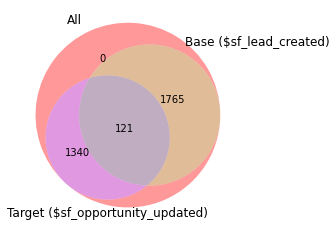

In [ ]:
venn3([ae_users, be_users, usr_users], set_labels=['All', f'Base ({list(be_events)[0]})', f'Target ({list(usr_events)[0]})'])

In [ ]:
print(len(ae_users), 'All users')
print(len(be_users), f'Base event ("{list(be_events)[0]}") users')
print(len(usr_users), f'Target event ("{list(usr_events)[0]}") users')

3226 All users
1886 Base event ("$sf_lead_created") users
1461 Target event ("$sf_opportunity_updated") users


In [ ]:
print(len(ae_users.intersection(be_users)), 'all and base users')
print(len(be_users.intersection(usr_users)), 'base and target users')
print(len(usr_users.intersection(ae_users)), 'all and target users')

1886 all and base users
121 base and target users
1461 all and target users


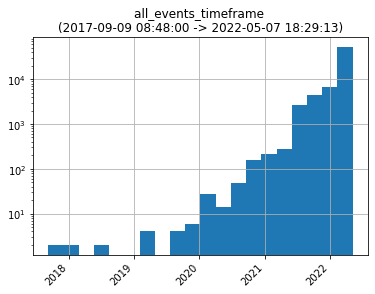

In [ ]:
from matplotlib import pyplot as plt
ae_df['et'] = pd.to_datetime(ae_df['et'], unit='s')
ax = ae_df['et'].hist(bins=20)
ax.set_yscale('log')
_ = ax.set_title(f"all_events_timeframe \n({ae_df['et'].min()} -> {ae_df['et'].max()})")
_ = plt.xticks(rotation=45, ha = 'right')

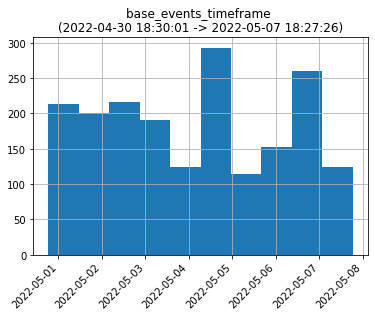

In [ ]:
be_df['et'] = pd.to_datetime(be_df['et'], unit='s')
ax = be_df['et'].hist()
_ = plt.xticks(rotation=45, ha = 'right')
_ = ax.set_title(f"base_events_timeframe \n({be_df['et'].min()} -> {be_df['et'].max()})")

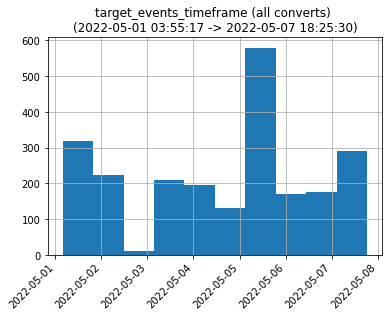

In [ ]:
usr_df['ts'] = pd.to_datetime(usr_df['ts'], unit='s')
ax = usr_df['ts'].hist()
_ = plt.xticks(rotation=45, ha = 'right')
_ = ax.set_title(f"target_events_timeframe (all converts) \n({usr_df['ts'].min()} -> {usr_df['ts'].max()})")

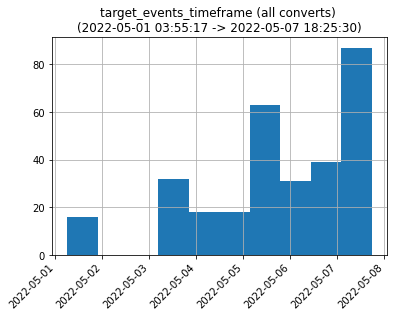

In [ ]:
ax = usr_df[usr_df['uci'].isin(be_users)]['ts'].hist()
_ = plt.xticks(rotation=45, ha = 'right')
_ = ax.set_title(f"target_events_timeframe (all converts) \n({usr_df['ts'].min()} -> {usr_df['ts'].max()})")

## 3.3. Filter out Rare events

In [ ]:
all_events = set(ae_df['en'])
all_users = set(ae_df['uid'])

In [ ]:
df = ae_df

In [ ]:
#@title
uid_tf_map = df[['uid', 'en']].groupby('uid').apply(lambda x: Counter(x['en'])).to_dict()
events_list = []
for _, d in uid_tf_map.items():
    events_list.extend(list(d))
df_map = Counter(events_list)

In [ ]:
df_thres = DEFAULT_EVENT_DF_THRES
df_df = pd.DataFrame({'df': df_map})
df_df[df_df['df'] <= df_thres]

,df
SF_lead_created,1
designcafe.com/p/home-interiors-designs,1
designcafe.com/p/home-interiors-designs-hyderabad,2
dev.designcafe.com,1
www.designcafe.com/blog/bathroom-interiors/bathroom-cabinet-designs,1
...,...
www.designcafe.com/thank-you/#18062,1
www.designcafe.com/thank-you/#contactUsModal,1
www.designcafe.com/thank-you/#kitchen-designs,2
www.designcafe.com/thank-you/#personalised-design,1


In [ ]:
rare_events = set(df_df[df_df['df'] <= df_thres].index)
special_rare_events = {e for e in rare_events if e.startswith('$')}

In [ ]:
df = df[~df['en'].isin(rare_events.difference(special_rare_events))]

In [ ]:
base_event = list(be_events)[0]
tgt_event = list(usr_events)[0]

## 3.4. Analyse Event Stream (Optional)

In [ ]:

user_event_stream = df[['uid', 'et', 'en', 'epr:$is_first_session']].groupby(['uid']).apply(lambda x: list(sorted(zip(x['et'], x['en']))))
def analyse_stream(stream):
    code_map = {base_event: 'b', tgt_event: 't'\
    , '$session': 's'}
    # u = list(stream.index())[0]
    # amt = usr_amt_map.get(u, -1)
    return(''.join([code_map.get(x[-1], '-') for x in stream]))
user_event_stream.apply(analyse_stream).value_counts()

b--                                  337
b---                                 264
s---b-----                            63
s---b----                             58
s--b-----                             47
                                    ... 
s---b------------tt----tt              1
s---b------------tt----s-t--ttt        1
s---b-------------t-t----t--t-tt       1
b--t----t--tttt                        1
s-s---b--------------t-t---t--ttt      1
Length: 1798, dtype: int64

In [ ]:
shortened_df = pd.DataFrame(user_event_stream.apply(analyse_stream).apply(shorten_stream_code).value_counts()).rename(columns={0: 'freq'})
shortened_df['perc'] = (shortened_df['freq'] * 100.0 / shortened_df['freq'].sum()).round(2)
shortened_df['conv'] = list(map(lambda x: 't' in x, shortened_df.index))
shortened_df[shortened_df['conv']]

,freq,perc,conv
b-t-t-t,109,3.38,True
b-t-t-t-,99,3.07,True
b-t-t-,97,3.01,True
b-t-t-t-t,95,2.94,True
s-b-t-t-t,64,1.98,True
...,...,...,...
s-s-b-s-t-t-t-t-,1,0.03,True
s-s-b-t-t-t-t-ts-t-t-t-t-t-t-t-t-t-t,1,0.03,True
s-b-s-s-s-s-s-s-s-s-s-s-t-t-s-t-t-,1,0.03,True
s-b-s-t-t-t-s-t,1,0.03,True


In [ ]:
shortened_df[shortened_df['conv']][['freq', 'perc']].sum()

freq    1462.00
perc      44.89
dtype: float64

In [ ]:
# 1764 users (54.68%) perform the base event, and don't convert.
# 1462 users (45.29%) perform the base event, and convert (with a zero or non-zero amount).

# 4. Feature Engineering

## 4.1. Base data

In [ ]:
# Segregate all base events.
base_df = df[df['en'] == base_event].sort_values('et', ascending=True)
print('Original data:', base_df.shape)
base_df = base_df.drop_duplicates(subset='uid', keep='first')
print('Deduplicated data:', base_df.shape)

Original data: (3270, 787)
Deduplicated data: (3226, 787)


## 4.2. Compute feature statistics (meta-data)

In [ ]:
n = base_df.shape[0]
ignored_cols = {'upr:$identifiers'}
metadata = []
for i, c in tqdm(enumerate(base_df.columns), total=base_df.shape[1]):
    if c in ignored_cols:
        continue
    try:
        nu = base_df[c].nunique()
        pu = round(nu*100.0/n, 2)
        nn_base_df = base_df[~base_df[c].isna()]
        nnn = nn_base_df.shape[0]
        pnn = round(nnn*100.0/n, 2)
        nnnu = nn_base_df[c].nunique()
        pnnu = round(nnnu*100.0/nnn if nnn != 0 else 0, 2)
        eg = nn_base_df[c].iloc[0] if nnn > 0 else None
        tp = nn_base_df[c].dtype
    except Exception:
        print(c)
        raise Exception
    meta_map = {'i': i,
                'col': c,
                'num_uniq': nu,
                'perc_uniq': pu,
                'num_nonnull': nnn,
                'perc_nonnull': pnn,
                'num_nonnull_uniq': nnnu,
                'perc_nonnull_uniq': pnnu,
                'example': eg,
                'dtype': tp}
    metadata.append(meta_map)
meta_df = pd.DataFrame(metadata)

  0%|          | 0/787 [00:00<?, ?it/s]

In [ ]:
base_df = base_df.drop(ignored_cols, axis=1)

In [ ]:
meta_df['uniq_status'] = None
meta_df['null_status'] = None
meta_df.loc[meta_df['num_nonnull'] == 0, 'null_status'] = ALL_NULLS
meta_df.loc[(meta_df['perc_nonnull'] <= 100-MOST_NULL_PERC_THRES) & (meta_df['num_nonnull'] > 0), 'null_status'] = MOST_NULLS
meta_df.loc[meta_df['perc_uniq'] == 100.0, 'uniq_status'] = ALL_UNIQS
meta_df.loc[(meta_df['perc_uniq'] >= MOST_UNIQ_PERC_THRES) & (meta_df['perc_uniq'] < 100.0), 'uniq_status'] = MOST_UNIQS
meta_df.loc[meta_df['perc_nonnull_uniq'] == 100.0, 'nn_uniq_status'] = NN_ALL_UNIQS
meta_df.loc[(meta_df['perc_nonnull_uniq'] >= NN_MOST_UNIQ_PERC_THRES) & (meta_df['perc_nonnull_uniq'] < 100.0), 'nn_uniq_status'] = NN_ALL_UNIQS

## 4.3. Process custom feature rules

In [ ]:
base_df = base_df.drop(CUST_DEL_COLS.intersection(base_df.columns), axis=1)

null_cols = set(meta_df[meta_df['null_status'].isin({ALL_NULLS})]['col'].unique())
base_df = base_df.drop(null_cols.intersection(base_df.columns), axis=1)

uniq_cols = set(meta_df[meta_df['uniq_status'].isin({ALL_UNIQS})]['col'].unique())
base_df = base_df.drop((uniq_cols.intersection(base_df.columns)).difference(CUST_KEEP_UNIQ_COLS), axis=1)

has_date_cols = set(meta_df[meta_df['col'].apply(lambda x: 'date' in x)]['col'].unique())
has_time_cols = set(meta_df[meta_df['col'].apply(lambda x: 'time' in x)]['col'].unique()).union(CUST_TIME_COLS)
dt_cols = has_date_cols.union(has_time_cols)

nonnumeric_dt_cols = dt_cols.difference(numeric_dt_cols)
base_df = base_df.drop(nonnumeric_dt_cols.intersection(base_df.columns), axis=1)


for c in FORCED_CAT_COLS:
    base_df[c] = base_df[c].astype(str)

for c in FORCED_NUM_COLS:
    base_df[c] = base_df[c].astype(float)

## 4.4. Add Target column

In [ ]:
base_df['$target_amt'] = base_df['uid'].apply(lambda x: usr_amt_map.get(x, (0, None))[0])

## 4.5. Null value imputation

In [ ]:
dtypes_map = base_df.dtypes.apply(str).to_dict()
for c, t in tqdm(dtypes_map.items()):
    if t == 'object':
        try:
            base_df[c] = base_df[c].apply(lambda x: 'NULL' if x in POSSIBLE_NULLS else x)
        except TypeError:
            print(c)
            raise TypeError
        base_df[c] = base_df[c].fillna('NULL')
        base_df[c] = base_df[c].apply(str)
    else:
        base_df[c] = base_df[c].fillna(0)

  0%|          | 0/352 [00:00<?, ?it/s]

## 4.6. Prepare data matrices X and y

In [ ]:
base_df.index = base_df['uid']
base_df.index.name = None
X = base_df.drop(['$target_amt', 'uid'], axis=1)
y = base_df['$target_amt']

## 4.7. Prepare list of numerical and categorical features for CatBoost

In [ ]:
categorical_cols_set = {x for x, t in dtypes_map.items() if t == 'object'}
numeric_cols_set = set(df.columns).difference(categorical_cols_set)

In [ ]:
feat_list = [c for c in X.columns]
categorical_feat_enum_list = [(i, c) for i, c in enumerate(feat_list) if c in categorical_cols_set]
numerical_feat_enum_list = [(i, c) for i, c in enumerate(feat_list) if c in numeric_cols_set]
categorical_feat_ids = [x[0] for x in categorical_feat_enum_list]
numerical_feat_ids = [x[0] for x in numerical_feat_enum_list]

# 5. Train classifiers and regressers

## 5.1. Quick prep

In [ ]:
y_cls = y.apply(lambda x: x>0)

In [ ]:
zreg_data = {'X': X, 'y': y}
cls_data = {'X': X, 'y': y_cls}
nzreg_data = {'X': X[y_cls], 'y': y[y_cls]}

## 5.2. Regression on full data

In [ ]:
data = zreg_data
model, data_split = train_regressor(data['X'], data['y'], categorical_feat_ids=categorical_feat_ids, silent=True)
perf_df = get_model_perf(model, data_split)
tr_df, te_df = get_compare_dfs(model, data_split)
perf_df

,param_value
depth,4
iterations,100
l2_leaf_reg,0.5
learning_rate,0.1
loss_function,RMSE
verbose,0
algorithm,CatBoostRegressor
test_split_ratio,0.2
train_rmse,714567.9474
train_r2,0.8191


In [ ]:
full_reg_tr_df = tr_df.copy(deep=True)
full_reg_te_df = te_df.copy(deep=True)

In [ ]:
cols = ['actual_deal_value (A)', 'predicted_deal_value (P)'] # one or more

Q1 = tr_df[cols].quantile(0.05)
Q3 = tr_df[cols].quantile(0.95)
IQR = Q3 - Q1

outlier_filter = ((tr_df[cols] < (Q1 - 1.5 * IQR)) |(tr_df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

tr_df[outlier_filter]

,uid,actual_deal_value (A),predicted_deal_value (P),abs_error (|A-P|),rel_error (|A-P|/A)
2451,8197141787,1966581.00,2.547890e+06,5.813087e+05,0.2956
1236,9700289690,81919860.00,5.423960e+07,2.768026e+07,0.3379
194,7090598699,1458446.20,2.442236e+06,9.837894e+05,0.6745
99,9869740912,4511056.50,9.976583e+05,3.513398e+06,0.7788
1000,8591267087,728157.94,2.348991e+06,1.620833e+06,2.2259
1522,8886141155,1131856.00,3.840674e+06,2.708818e+06,2.3933
1131,9578938813,1249188.80,4.650961e+06,3.401772e+06,2.7232
2084,9844685189,472000.00,2.520426e+06,2.048426e+06,4.3399
319,9972817349,286861.00,2.288467e+06,2.001606e+06,6.9776
812,8792383957,632446.00,1.442637e+07,1.379392e+07,21.8104


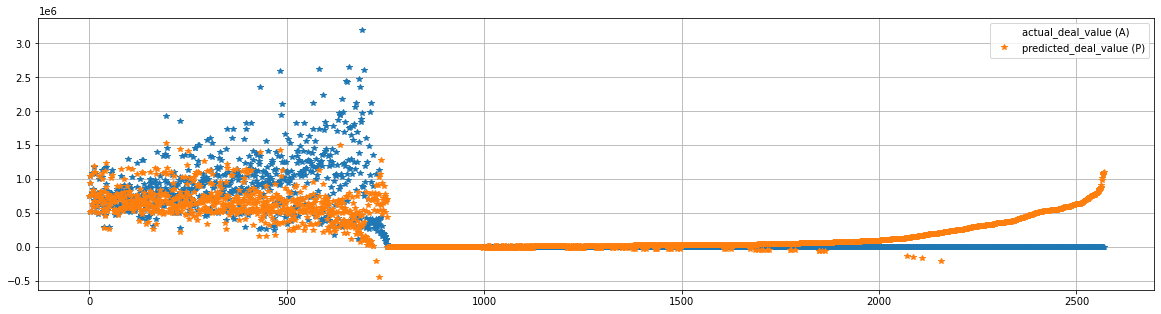

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
tr_df[~outlier_filter].reset_index().plot(y='actual_deal_value (A)', linestyle='', marker='*', kind='line', ax=ax)
tr_df[~outlier_filter].reset_index().plot(y='predicted_deal_value (P)', linestyle='', marker='*', kind='line', ax=ax)
ax.grid(True)

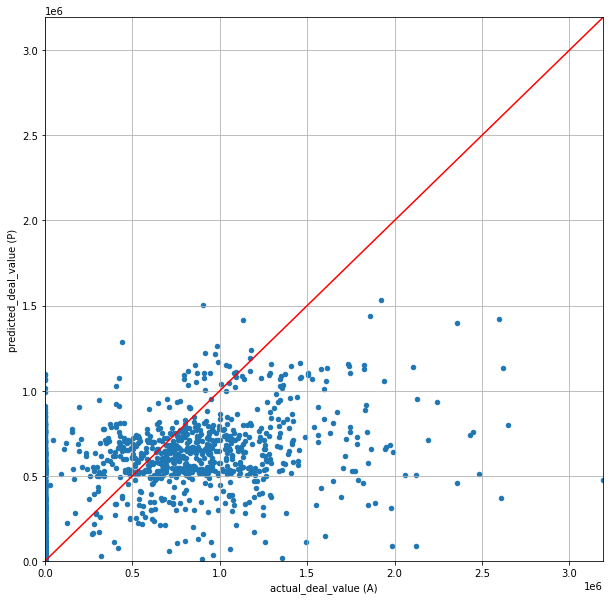

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
tr_df[~outlier_filter].plot(x='actual_deal_value (A)', y='predicted_deal_value (P)', kind='scatter', ax=ax)
maxx = tr_df[~outlier_filter]['actual_deal_value (A)'].max()
maxy = tr_df[~outlier_filter]['predicted_deal_value (P)'].max()
maxval = max(maxx, maxy)
ax.grid(True)
ax.set_xlim(0, maxval)
ax.set_ylim(0, maxval)
ax.plot([0, maxval], [0, maxval], 'r')

## 5.3. Regression on non-zero data

In [ ]:
data = nzreg_data
model, data_split = train_regressor(data['X'], data['y'], categorical_feat_ids=categorical_feat_ids, silent=True)
perf_df = get_model_perf(model, data_split)
perf_df

,param_value
depth,4
iterations,100
l2_leaf_reg,0.5
learning_rate,0.1
loss_function,RMSE
verbose,0
algorithm,CatBoostRegressor
test_split_ratio,0.2
train_rmse,2950119.2838
train_r2,0.0128


In [ ]:
tr_df, te_df = get_compare_dfs(model, data_split)
tr_df

,uid,actual_deal_value (A),predicted_deal_value (P),abs_error (|A-P|),rel_error (|A-P|/A)
306,57734,829108.60,8.293756e+05,2.669811e+02,0.0003
69,53723,1656571.90,1.658089e+06,1.516853e+03,0.0009
47,24241,1083604.20,1.079814e+06,3.789704e+03,0.0035
76,50663,1154222.00,1.159360e+06,5.138048e+03,0.0045
754,35533,984945.06,9.900055e+05,5.060439e+03,0.0051
...,...,...,...,...,...
84,24411,622682.25,1.082741e+07,1.020473e+07,16.3883
258,20021,105604.87,1.877947e+06,1.772342e+06,16.7826
66,53790,240008.22,4.462206e+06,4.222198e+06,17.5918
217,35968,397634.03,9.949912e+06,9.552278e+06,24.0227


In [ ]:
cols = ['actual_deal_value (A)', 'predicted_deal_value (P)'] # one or more

Q1 = tr_df[cols].quantile(0.05)
Q3 = tr_df[cols].quantile(0.95)
IQR = Q3 - Q1

outlier_filter = ((tr_df[cols] < (Q1 - 1.5 * IQR)) |(tr_df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

tr_df[outlier_filter]

,uid,actual_deal_value (A),predicted_deal_value (P),abs_error (|A-P|),rel_error (|A-P|/A)
396,52135,4511056.50,2.214264e+06,2.296793e+06,0.5091
218,38306,81919860.00,8.245585e+06,7.367428e+07,0.8993
603,14922,728157.94,9.473072e+06,8.744914e+06,12.0096
84,24411,622682.25,1.082741e+07,1.020473e+07,16.3883
217,35968,397634.03,9.949912e+06,9.552278e+06,24.0227


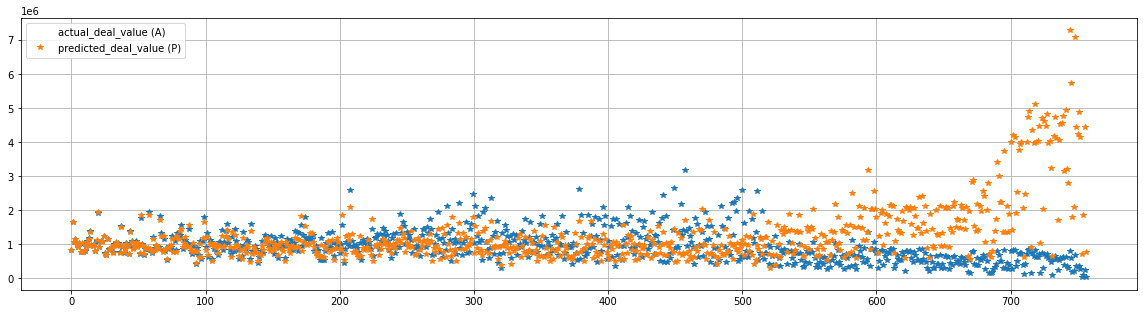

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
tr_df[~outlier_filter].reset_index().plot(y='actual_deal_value (A)', linestyle='', marker='*', kind='line', ax=ax)
tr_df[~outlier_filter].reset_index().plot(y='predicted_deal_value (P)', linestyle='', marker='*', kind='line', ax=ax)
ax.grid(True)

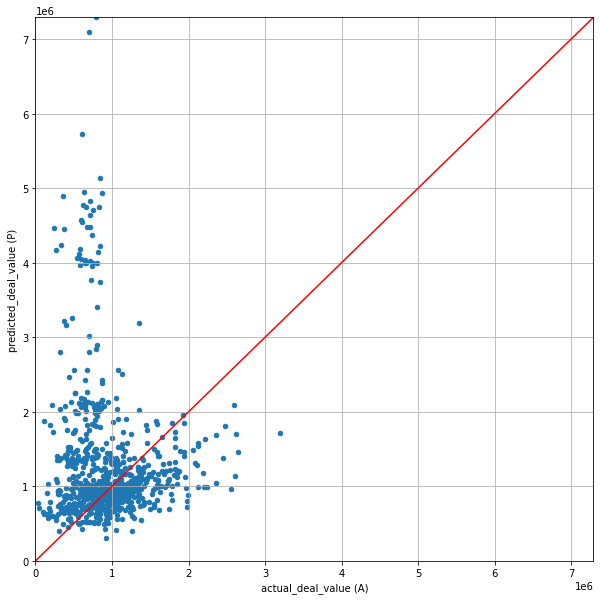

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
tr_df[~outlier_filter].plot(x='actual_deal_value (A)', y='predicted_deal_value (P)', kind='scatter', ax=ax)
maxx = tr_df[~outlier_filter]['actual_deal_value (A)'].max()
maxy = tr_df[~outlier_filter]['predicted_deal_value (P)'].max()
maxval = max(maxx, maxy)
ax.grid(True)
ax.set_xlim(0, maxval)
ax.set_ylim(0, maxval)
ax.plot([0, maxval], [0, maxval], 'r')

## 5.4. Classifier for convert / no-convert

In [ ]:
data = cls_data
model, data_split = train_classifier(data['X'], data['y'], categorical_feat_ids=categorical_feat_ids, silent=True)
# perf_df = get_model_perf(model, data_split)
# perf_df

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve
X_train, X_test, y_train, y_test = [data_split[x] for x in ['X_train', 'X_test', 'y_train', 'y_test']]
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pp = model.predict_proba(X_train)[:,1]
test_pp = model.predict_proba(X_test)[:,1]

train_acc = accuracy_score(y_train.apply(str), train_pred)
test_acc = accuracy_score(y_test.apply(str), test_pred)
# train_auc = 
# train_auc = (np.sqrt(mean_squared_error(y_train, train_pred)))
# test_auc = r2_score(y_train, train_pred)
# test_pred = model.predict(X_test)
# test_rmse = (np.sqrt(mean_squared_error(y_test, test_pred)))
# test_r2 = r2_score(y_test, test_pred)
# model_df = pd.DataFrame({'param_value': model._get_params()}).T
# model_df['algorithm'] = 'CatBoostRegressor'
# model_df['test_split_ratio'] = 0.2
# model_df['train_rmse'] = round(train_rmse, 4)
# model_df['train_r2'] = round(train_r2, 4)
# model_df['test_rmse'] = round(test_rmse, 4)
# model_df['test_r2'] = round(test_r2, 4)
# model_df = model_df.T

In [ ]:
tr_clf_df = pd.DataFrame({'true_label': y_train.apply({True: 'Converts', False: 'Doesn\'t Convert'}.get),
              'pred_label': map({'True': 'Converts', 'False': 'Doesn\'t Convert'}.get, train_pred),
              'pred_prob': train_pp})

In [ ]:
te_clf_df = pd.DataFrame({'true_label': y_test.apply({True: 'Converts', False: 'Doesn\'t Convert'}.get),
              'pred_label': map({'True': 'Converts', 'False': 'Doesn\'t Convert'}.get, test_pred),
              'pred_prob': test_pp})

In [ ]:
final_tr_df = pd.merge(full_reg_tr_df, tr_clf_df, left_on='uid', right_index=True, how='outer')
final_tr_df

,uid,actual_deal_value (A),predicted_deal_value (P),abs_error (|A-P|),rel_error (|A-P|/A),true_label,pred_label,pred_prob
1421,919686058599,752496.00,7.533411e+05,8.451294e+02,1.100000e-03,Converts,Converts,0.887318
1602,9550900653,948443.44,9.507685e+05,2.325092e+03,2.500000e-03,Converts,Converts,0.781069
2366,8019496009,513964.10,5.125056e+05,1.458494e+03,2.800000e-03,Converts,Converts,0.714520
993,9538176743,1050164.60,1.046060e+06,4.104639e+03,3.900000e-03,Converts,Converts,0.867775
206,+919986480412,528864.50,5.262769e+05,2.587617e+03,4.900000e-03,Converts,Converts,0.535737
...,...,...,...,...,...,...,...,...
1116,7619187856,0.00,1.017702e+06,1.017702e+06,1.017701e+06,Doesn't Convert,Converts,0.830842
1800,7506933810,0.00,1.064118e+06,1.064118e+06,1.064117e+06,Doesn't Convert,Converts,0.908994
1803,9731723482,0.00,1.069818e+06,1.069818e+06,1.069817e+06,Doesn't Convert,Converts,0.782496
2267,7204792080,0.00,1.092983e+06,1.092983e+06,1.092982e+06,Doesn't Convert,Converts,0.829401


In [ ]:
final_te_df = pd.merge(full_reg_te_df, te_clf_df, left_on='uid', right_index=True, how='outer')
final_te_df

,uid,actual_deal_value (A),predicted_deal_value (P),abs_error (|A-P|),rel_error (|A-P|/A),true_label,pred_label,pred_prob
270,9989775270,592764.00,5.936541e+05,8.901458e+02,1.500000e-03,Converts,Converts,0.830611
276,8511937352,731887.06,7.419471e+05,1.006009e+04,1.370000e-02,Converts,Converts,0.564728
195,9908106545,1070512.00,1.091477e+06,2.096472e+04,1.960000e-02,Converts,Converts,0.952730
461,9545545838,428001.20,4.114407e+05,1.656048e+04,3.870000e-02,Converts,Converts,0.592663
633,7702682753,707107.20,6.783561e+05,2.875109e+04,4.070000e-02,Converts,Converts,0.925585
...,...,...,...,...,...,...,...,...
504,9848276255,0.00,8.897897e+05,8.897897e+05,8.897887e+05,Doesn't Convert,Converts,0.840081
2,9972411944,0.00,8.974550e+05,8.974550e+05,8.974540e+05,Doesn't Convert,Converts,0.694430
326,7305167192,0.00,9.547711e+05,9.547711e+05,9.547701e+05,Doesn't Convert,Converts,0.908130
13,9994386159,0.00,9.650997e+05,9.650997e+05,9.650987e+05,Doesn't Convert,Converts,0.845186


In [ ]:
final_tr_df.to_csv(os.path.join(data_home, 'train_compare_results_v2.0.tsv'), index=False, sep='\t')
final_te_df.to_csv(os.path.join(data_home, 'test_compare_results_v2.0.tsv'), index=False, sep='\t')

In [ ]:
print('Train accuracy:', round(train_acc*100, 2), '%')
print('Test accuracy:', round(test_acc*100, 2), '%')

Train accuracy: 89.61 %
Test accuracy: 88.7 %


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


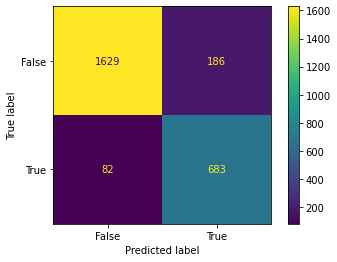

In [ ]:
plot_confusion_matrix(model, X_train, y_train.apply(str))

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


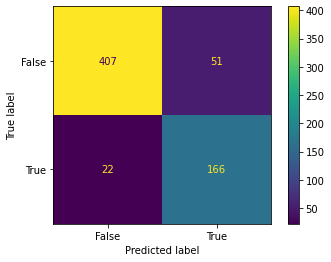

In [ ]:
plot_confusion_matrix(model, X_test, y_test.apply(str))  

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


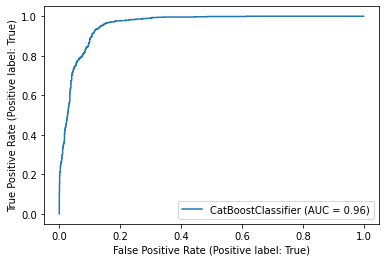

In [ ]:
plot_roc_curve(model, X_train, y_train.apply(str)) 

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


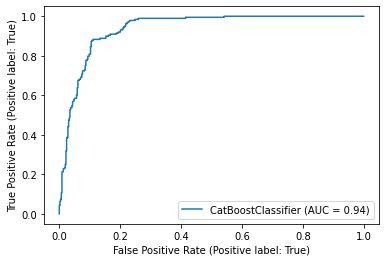

In [ ]:
plot_roc_curve(model, X_test, y_test.apply(str)) 

## 5.5. Store results to Google Sheets

In [ ]:
# train_compare_df.to_csv(os.path.join(data_home, 'train_compare_results.tsv'), index=False, sep='\t')
# test_compare_df.to_csv(os.path.join(data_home, 'test_compare_results.tsv'), index=False, sep='\t')

# Appendix

In [ ]:
# @title
gcp_project_id = 'factors-staging'
bucket_name = 'factors-staging-v2'
proj_id = '399'
mode = ['m']
dates = ['20220101', '20220201']
events_file_name = 'events.txt'
events_file_src_paths = [f'gs://{bucket_name}/projects/{proj_id}/events/m/{date}/{events_file_name}' for date in dates]
events_file_tmp_paths = [f'/tmp/{date}.txt' for date in dates]

## Copy events file to local and count rows

In [ ]:
#@title
!gcloud config set project {gcp_project_id}

# !gsutil cp {events_file_src_paths[0]} {events_file_tmp_paths[0]}
# !ls {events_file_tmp_paths[0]}
# !wc -l {events_file_tmp_paths[0]}

# !gsutil cp {events_file_src_paths[1]} {events_file_tmp_paths[1]}
# !ls {events_file_tmp_paths[1]}
# !wc -l {events_file_tmp_paths[1]}

## Get sample data
- Randomly sample some users from a month's data

### Imports

In [ ]:
#@title
from collections import defaultdict
import json
import numpy as np
import os
import pandas as pd
from pprint import pprint
import shutil
from tqdm.notebook import tqdm

### Function defs

In [ ]:
#@title
HS_DSC_EN = '$hubspot_deal_state_changed' 
FS_EN = '$form_submitted'
DEFAULT_SAMPLE_FOLDER_ROOT = '/content/drive/MyDrive/cloud_storage/sample_data'
DEFAULT_BASE_EN = FS_EN
DEFAULT_TARGET_EN = HS_DSC_EN


def parse_event(line):
    event = json.loads(line)
    return event


def flatten_properties(event):
    epr = {f'epr:{k}': v for k, v in event['epr'].items()}
    upr = {f'upr:{k}': v for k, v in event['upr'].items()}
    event.pop('epr', None)
    event.pop('upr', None)
    event.update(epr)
    event.update(upr)


def tmp_read_and_sample_data(date='20220101',
                             users_sample_ratio=0.001,
                             n_rows=None,
                             base_en=DEFAULT_BASE_EN,
                             target_en=DEFAULT_TARGET_EN):
    eligible_events = {base_en, target_en}
    user_events_count_dist = defaultdict(int)
    user_events = []
    prev_user_id = None
    f_name = f'/tmp/{date}.txt'
    i = 0
    sampled_data = []
    print('Parsing and sampling (if ratio < 1) data...')
    with open(f_name) as f:
        for line in tqdm(f, total = n_rows):
            event = parse_event(line)
            user_id = event['uid']
            if prev_user_id is None:
                prev_user_id = user_id
            if user_id == prev_user_id:
                user_events.append(event)
            else:
                if (users_sample_ratio >= 1) or (np.random.rand() < users_sample_ratio):
                    uniq_events = {e['en'] for e in user_events}
                    if len(uniq_events.intersection(eligible_events)) > 0: # If at least one event is eligible
                        sampled_data.append(user_events)
                user_events = [event]
            prev_user_id = user_id
            i += 1
        uniq_events = {e['en'] for e in user_events}
        if len(uniq_events.intersection(eligible_events)) > 0: # If at least one event is eligible
            sampled_data.append(user_events)
    print('Done parsing.')
    print('Flattening properties...')
    for i in tqdm(range(len(sampled_data))):
        for j in range(len(sampled_data[i])):
            flatten_properties(sampled_data[i][j])
    return sampled_data


def write_sampled_data(sampled_data,
                       proj_id,
                       date,
                       ratio=1,
                       sample_folder_root=DEFAULT_SAMPLE_FOLDER_ROOT,
                       base_en=DEFAULT_BASE_EN,
                       target_en=DEFAULT_TARGET_EN):
    sample_folder = f'{sample_folder_root}/{proj_id}/{date}'
    sample_path = f'{sample_folder}/events_b={base_en}_t={target_en}.{ratio}.sample.txt'
    try:
        shutil.rmtree(sample_path)
    except:
        pass
    try:
        f = open(sample_path, 'a')
    except:
        os.makedirs(sample_folder, exist_ok=True)
        f = open(sample_path, 'a')
    for events in tqdm(sampled_data):
        for e in events:
            f.write(json.dumps(e) + '\n')
    f.close()


def read_sample_data(proj_id='399',
                     date='20220101',
                     n_rows=None,
                     ratio=1,
                     sample_folder_root=DEFAULT_SAMPLE_FOLDER_ROOT,
                     base_en=DEFAULT_BASE_EN,
                     target_en=DEFAULT_TARGET_EN):
    user_events = []
    prev_user_id = None
    f_name = f'{sample_folder_root}/{proj_id}/{date}/events_b={base_en}_t={target_en}.{ratio}.sample.txt'
    i = 0
    sample_data = []
    with open(f_name) as f:
        for line in tqdm(f, total = n_rows):
            event = parse_event(line)
            user_id = event['uid']
            if prev_user_id is None:
                prev_user_id = user_id
            if user_id == prev_user_id:
                user_events.append(event)
            else:
                sample_data.append(user_events)
                user_events = [event]
            prev_user_id = user_id
            i += 1
        sample_data.append(user_events)
    return sample_data


def get_sample_data(proj_id='399',
                    date='20220101',
                    n_rows=None,
                    n_sample_rows=None,
                    users_sample_ratio=0.001,
                    sample_folder_root=DEFAULT_SAMPLE_FOLDER_ROOT,
                    base_en=DEFAULT_BASE_EN,
                    target_en=DEFAULT_TARGET_EN):
    try:
        print('Reading from cache...', end='')
        data = read_sample_data(proj_id, date, n_sample_rows, users_sample_ratio, sample_folder_root, base_en=base_en, target_en=target_en)
        print(' Done.')
    except FileNotFoundError:
        print('\nCache not found! Resampling...', end='')
        data = tmp_read_and_sample_data(date, users_sample_ratio, n_rows, base_en=base_en, target_en=target_en)
        print(' Done.')
        print('Writing to cache...', end='')
        write_sampled_data(data, proj_id, date, users_sample_ratio, sample_folder_root, base_en=base_en, target_en=target_en)
        print(' Done.')
    return data

### Count stats table filled in retrospect

In [ ]:
#@title
proj_date_sample_nrows_map = {'399': {'20220626': {1: 35547,
                                                   0.1: None,
                                                   0.01: None,
                                                   0.001: None
                                                   },
                                      '20220101': {1: 2021380,
                                                   0.1: None,
                                                   0.01: None,
                                                   0.001: None
                                                   },
                                      '20220201': {1: 2605936,
                                                   0.1: None,
                                                   0.01: None,
                                                   0.001: None
                                                   }
                                      }
                              }

### Sample users and read into a dataframe

In [ ]:
#@title
sample_ratio = 1
dfs = {}
for date in dates:
    n_rows, n_sample_rows = proj_date_sample_nrows_map[proj_id][date][1], proj_date_sample_nrows_map[proj_id][date][sample_ratio]

    data = get_sample_data(proj_id, date, n_rows, n_sample_rows, sample_ratio)
    temp = []
    for events in data:
        temp.extend(events)
    del data
    print('Preparing dataframe...')
    df = pd.DataFrame(temp)
    dfs[date] = df
    del temp
    print(df.shape[0], 'rows,', df['uid'].nunique(), 'unique users.')
uids0 = set(dfs[dates[0]].uid.unique())
uids1 = set(dfs[dates[1]].uid.unique())
print(len(uids0), len(uids1), len(uids0.intersection(uids1)))
df = pd.concat([dfs[date] for date in dates]).sort_values(['uid', 'et']).reset_index(drop=True)
del dfs

In [ ]:
#@title
def parse_num(x):
    if x is None or x is np.nan or x is True or x is False:
        return None
    try:
        num = float(x)
        return num
    except Exception:
        return None

In [ ]:
#@title
def find_fs_and_dv_users(e_list):
    fs_flag = False
    dsc_flag = False
    dv_status = None
    first_nz_dv = None
    first_dv = parse_num(list(e_list[value_upr])[0])
    for en, dv in zip(e_list['en'], e_list[value_upr]):
        dv = parse_num(dv)
        if en == '$form_submitted':
            if not dsc_flag:
                fs_flag = True
                if dv is not None and dv > 0:
                    return True
                return False
            return False
        if en == '$hubspot_deal_state_changed':
            dsc_flag = True
            if not fs_flag:
                if first_nz_dv is not None:
                    return True
                return False
            return False
        if dv is not None and dv > 0:
            if first_nz_dv is None:
                first_nz_dv = dv

tdf = df[['uid', 'en', value_upr]][df['en'].isin({'$form_submitted', '$hubspot_deal_state_changed'})].groupby('uid').apply(find_fs_and_dv_users)
fs_with_nzdv_users = set(tdf[tdf].index)
print('Users with non-zero deal value at time of form_submit:', len(fs_with_nzdv_users))

In [ ]:
#@title
from collections import Counter

def fetch_number_from_list(value_list):
    zero_flag = False
    nonzero_nums = []
    null_flag = False
    for x in value_list:
        try:
            n = float(x)
            if n == 0:
                zero_flag = True
            elif n is np.nan:
                raise Exception
            else:
                nonzero_nums.append(n)
        except:
            null_flag = True
    if null_flag and not zero_flag and len(nonzero_nums) == 0:
        return None
    if zero_flag and len(nonzero_nums) == 0:
        return 0
    if len(nonzero_nums) > 0:
        return nonzero_nums[0]
            
def analyse_deal_values(deal_value_list):
    values = set(deal_value_list)
    n = fetch_number_from_list(list(values))
    if n is None:
        return np.nan
    return n

assert analyse_deal_values([np.nan, np.nan, np.nan]) is np.nan, 'Error'
assert analyse_deal_values([0, np.nan, np.nan]) == 0, 'Error' 
assert analyse_deal_values([0, 0, 0]) == 0, 'Error'
assert analyse_deal_values([0, 10, np.nan]) == 10, 'Error'
assert analyse_deal_values([np.nan, 10, np.nan]) == 10, 'Error'
assert analyse_deal_values([0, 10, 0]) == 10, 'Error'
assert analyse_deal_values([20, 10, np.nan]) in {10, 20}, 'Error'

temp_df = df[['uid', value_upr]].groupby('uid').agg(analyse_deal_values)
deal_value_available_users = set(temp_df[~temp_df[value_upr].isna()].index)

In [ ]:
# df[df['en'] == '$hubspot_deal_state_changed']['upr:$hubspot_company_hs_total_deal_value'].replace('', 0).astype(float).fillna(0).value_counts()

In [ ]:
#@title
value_col = 'upr:$hubspot_company_hs_total_deal_value'
deal_value_freq_df = df[df['en'] == DEFAULT_TARGET_EN][['uid', value_col]].fillna(0).groupby('uid').agg(len)
mult_deal_value_users = set(deal_value_freq_df[deal_value_freq_df[value_col] > 1].index)
df[df['en'] == DEFAULT_TARGET_EN][df['uid'].isin(mult_deal_value_users)][['uid', 'et', value_col]].groupby('uid').agg(list)

In [ ]:
df.shape

### Events distribution

In [ ]:
e_freq_map = pd.DataFrame(df['en'].value_counts())


In [ ]:
all_events = set(df['en'])
all_users = set(df['uid'])

In [ ]:
#@title
from collections import Counter
uid_tf_map = df[['uid', 'en']].groupby('uid').apply(lambda x: Counter(x['en'])).to_dict()
events_list = []
for _, d in uid_tf_map.items():
    events_list.extend(list(d))
df_map = Counter(events_list)

In [ ]:
n = len(all_users)
# uid_tfidf_map = {u: {e: tf*(np.log(n/df_map[e]) + 1) for e, tf in e_tf_map.items()} for u, e_tf_map in uid_tf_map.items()}

In [ ]:
df_thres = 10
df_df = pd.DataFrame({'df': df_map})
df_df[df_df['df'] <= df_thres]

In [ ]:
rare_events = set(df_df[df_df['df'] <= df_thres].index)
special_rare_events = {e for e in rare_events if e.startswith('$')}

In [ ]:
len(rare_events), len(special_rare_events)

In [ ]:
df.shape[0], df[df['en'].isin(rare_events.difference(special_rare_events))].shape[0]

In [ ]:
df = df[~df['en'].isin(rare_events.difference(special_rare_events))]

In [ ]:
# del uid_tfidf_map, uid_tf_map
del events_list

In [ ]:
df['en'].nunique()

## Aggregate to get user-level data

- Remove users that have no "$session" event
- Set a target event that defines convert -- e.g., "www.chargebee.com/pricing"
- Derive class from event stream -- True for "session followed by target", and False for "session followed by no target".
- Add a "valid_feature_flag" so that features could be computed fairly. List of invalidations:
  - Invalidate pre-session events
  - Invalidate post-target events (including invalidating target event)

In [ ]:
# target_event = 'www.chargebee.com/pricing'
base_en = FS_EN
target_en = HS_DSC_EN
value_en = HS_DSC_EN
value_upr_suffix = '$hubspot_company_hs_total_deal_value'
value_upr = f'upr:{value_upr_suffix}'
hubspot_cols = [x for x in list(sorted(df.columns)) if 'hubspot' in x]
hs_cols_exc = [value_upr]

In [ ]:
df = df.drop(set(df.columns).intersection(set(hubspot_cols).difference(set(hs_cols_exc))), axis=1)

In [ ]:
df.shape

In [ ]:
df[df['en'].apply(lambda x: 'deal_state' in x)]

In [ ]:
#@title
def get_presession_users(event_stream):
    return get_prebase_users(event_stream, '$session')

def get_nosession_users(event_stream):
    return get_nobase_users(event_stream, '$session')

def get_prebase_users(event_stream, base_en=DEFAULT_BASE_EN):
    return event_stream[0][1] != base_en

def get_nobase_users(event_stream, base_en=DEFAULT_BASE_EN):
    return base_en not in {x[1] for x in event_stream}

user_event_stream = df[['uid', 'et', 'en', 'epr:$is_first_session']].groupby(['uid']).apply(lambda x: list(sorted(zip(x['et'], x['en'], x['epr:$is_first_session']))))
all_users = set(user_event_stream.index)
presession_users = set(user_event_stream[user_event_stream.apply(get_presession_users)].index)
nosession_users = set(user_event_stream[user_event_stream.apply(get_nosession_users)].index)
nonfirstsession_users = set(user_event_stream[~user_event_stream.apply(lambda x: x[0][-1]).fillna(False)].index)
ineligible_users = set.union(presession_users, nosession_users, nonfirstsession_users)

prebase_users = set(user_event_stream[user_event_stream.apply(get_prebase_users)].index)
nobase_users = set(user_event_stream[user_event_stream.apply(get_nobase_users)].index)

In [ ]:
print('A: All users:', len(all_users))
print('B: Users with no session at all:', len(nosession_users))
print('C: Users with first event not $session:', len(presession_users))
print('D: Users with first session having $is_first_session False:', len(nonfirstsession_users))
print('E: Ineligible users (=B or C or D):', len(ineligible_users), f"({round(len(ineligible_users)*100/len(all_users), 2)}% of total)")

print(f'F: Users with no base ({base_en}) at all:', len(nobase_users))
print(f'G: Users with first event not base ({base_en}):', len(prebase_users))

In [ ]:
nob_users_first_event_df = df[df['uid'].isin(nobase_users)].groupby('uid').agg(lambda x: list(x)[0]).reset_index()
nob_users_first_event_df['en'] = DEFAULT_BASE_EN
nob_users_first_event_df

In [ ]:
df = pd.concat([df, nob_users_first_event_df]).sort_values(['uid', 'et'])

In [ ]:
user_event_stream = df[['uid', 'et', 'en', 'epr:$is_first_session']].groupby(['uid']).apply(lambda x: list(sorted(zip(x['et'], x['en'], x['epr:$is_first_session']))))
all_users = set(user_event_stream.index)
presession_users = set(user_event_stream[user_event_stream.apply(get_presession_users)].index)
nosession_users = set(user_event_stream[user_event_stream.apply(get_nosession_users)].index)
nonfirstsession_users = set(user_event_stream[~user_event_stream.apply(lambda x: x[0][-1]).fillna(False)].index)
ineligible_users = set.union(presession_users, nosession_users, nonfirstsession_users)

prebase_users = set(user_event_stream[user_event_stream.apply(get_prebase_users)].index)
nobase_users = set(user_event_stream[user_event_stream.apply(get_nobase_users)].index)

In [ ]:
print('A: All users:', len(all_users))
# print('B: Users with no session at all:', len(nosession_users))
# print('C: Users with first event not $session:', len(presession_users))
# print('D: Users with first session having $is_first_session False:', len(nonfirstsession_users))
# print('E: Ineligible users (=B or C or D):', len(ineligible_users), f"({round(len(ineligible_users)*100/len(all_users), 2)}% of total)")

print(f'F: Users with no base ({base_en}) at all:', len(nobase_users))
print(f'G: Users with first event not base ({base_en}):', len(prebase_users))

In [ ]:
# df = df[~df['uid'].isin(nobase_users)]
# user_event_stream = user_event_stream[~user_event_stream.index.isin(nobase_users)]

In [ ]:
df[df['en'].apply(lambda x: 'deal_state' in x)]

In [ ]:
df.shape

In [ ]:
df.head(1)

In [ ]:
#@title
df[value_upr].fillna(0).value_counts()

In [ ]:
# to_drop = df.groupby('uid').apply(lambda x: (list(x['en'])[0] == DEFAULT_BASE_EN) and (list(x[value_upr].fillna(0))[0] > 0))
# to_drop[to_drop]

In [ ]:
from datetime import datetime, timedelta
#                    dd   hh   mm   ss
CONV_LIMIT_SECONDS = 14 * 24 * 60 * 60 # [14 days]
CONV_LIMIT_SECONDS = float('Inf') # [Infinite]
CONV_LIM_TOL_SECS  =       1 * 60 * 60 # [+1 hour]

FEAT_LIMIT_SECONDS =       1 * 60 * 60 # [1 hour]
FEAT_LIM_TOL_SECS  =           10 * 60 # [+10 mins]

# converts within 1 hour -> feature measured until convert
# converts after 1 hour -> feature measured until 1 hour
# doesn't convert but interacts for less than 1 hour -> feature measured for until last interaction
# doesn't convert but interacts for more than 1 hour -> feat measured until 1 hour

# Base cohort condition. Choose base cohort based on this.
# Num of users with no session. -- 
# is_first_session filter from properties

def get_cffi(event_stream, base_event=DEFAULT_BASE_EN, target_event=DEFAULT_TARGET_EN):
    # end-index as well as start-index.
    ci = None
    conv_flag = False
    first_feat_index = 0
    last_feat_index = 0
    first_session_time = datetime.utcfromtimestamp(event_stream[0][0])
    feat_limit_reached = False
    conv_limit_reached = False
    base_event_started = False
    for i, (et, en, _) in enumerate(event_stream):
        if (not base_event_started) and en == base_event:
            base_event_started = True
            first_feat_index = i
            first_base_event_time = datetime.utcfromtimestamp(et)
        if not base_event_started:
            continue
        if conv_limit_reached or conv_flag:
            break
        te = (datetime.utcfromtimestamp(et) - first_base_event_time).seconds
        if te > FEAT_LIMIT_SECONDS + FEAT_LIM_TOL_SECS:
            feat_limit_reached = True
        if te > CONV_LIMIT_SECONDS + CONV_LIM_TOL_SECS:
            conv_limit_reached = True
        if not conv_limit_reached:
            conv_flag = en == target_event
        if (not conv_flag) and (not feat_limit_reached):
            last_feat_index = i
    return (conv_flag, first_feat_index, last_feat_index)

df1 = pd.DataFrame({'ev_str': user_event_stream.apply(lambda x: [(i, et-x[0][0], en) for i, (et, en, _) in enumerate(x)]),
                    'cffi': user_event_stream.apply(get_cffi)})
unconverted_df = df1[df1['cffi'].apply(lambda x: not x[0])].head(10)
converted_df = df1[df1['cffi'].apply(lambda x: x[0])].head(10)

In [ ]:
value_users = set(user_event_stream[user_event_stream.apply(lambda x: value_en in [i[1] for i in x])].index)
value_users

In [ ]:
df['uid'].nunique()

In [ ]:

df[df['uid'].isin(value_users) & (df['en'] == value_en)][['uid', value_upr]]

In [ ]:
from pprint import pprint
import textwrap
# pprint(list(zip(df1['ev_str'], df1['cffi']))[:10])
print('Sample 10 non-converts:\n')
for uid, ev_str, cffi in zip(unconverted_df.index, unconverted_df['ev_str'], unconverted_df['cffi']):
    print('User:', uid)
    print(textwrap.fill(' -> '.join([f'{i}.{e}@{t}s' for i, t, e, in ev_str]), 180))
    print(f'=> converted: {cffi[0]}, feat_index_range: [{cffi[1]}, {cffi[2]}]')
    print()

In [ ]:
#@title
print('Sample 10 converts:\n')
for uid, ev_str, cffi in zip(converted_df.index, converted_df['ev_str'], converted_df['cffi']):
    print('User:', uid)
    print(textwrap.fill(' -> '.join([f'{i}.{e}@{t}s' for i, t, e, in ev_str]), 180))
    print(f'=> converted: {cffi[0]}, feat_index_range: [{cffi[1]}, {cffi[2]}]')
    print()

In [ ]:
cffi_dict = user_event_stream.apply(get_cffi).to_dict()
# df3 = pd.concat([user_event_stream, user_event_stream.apply(get_cffi)], axis=1).rename(columns = {0: 'stream', 1: 'cffi'})
df['conv'] = df['uid'].apply(lambda x: cffi_dict[x][0])
df['start_feat_index'] = df['uid'].apply(lambda x: cffi_dict[x][1])
df['end_feat_index'] = df['uid'].apply(lambda x: cffi_dict[x][2])
# df

In [ ]:
df.shape

In [ ]:
# del df1

In [ ]:
#@title
from collections import Counter
FEAT_KEY_SEQ = []
COUNT_FEAT_KEYS = set()
TIME_FEAT_KEYS = set()
EPR_FEAT_KEYS = set()
UPR_FEAT_KEYS = set()
def find_features(x):
    global COUNT_FEAT_KEYS, TIME_FEAT_KEYS, EPR_FEAT_KEYS, UPR_FEAT_KEYS
    first_index = cffi_dict[x['uid'].iloc[0]][1]
    last_index = cffi_dict[x['uid'].iloc[0]][2]
    event_first_index_map = {}
    # event_last_index_map = {}
    for i in range(first_index, last_index+1):
        en = x['en'].iloc[i]
        if en in event_first_index_map:
            # event_last_index_map[en] = i
            continue
        else:
            event_first_index_map[en] = i
            # event_first_index_map[en] = event_last_index_map[en] = i
    feat_dict = {}
    cols = list(x.columns)
    epr_cols = [c for c in cols if c.startswith('epr:')]
    upr_cols = [c for c in cols if c.startswith('upr:')]
    count_feat_dict = {f'{k}_count': v for k, v in dict(Counter(x['en'].iloc[first_index:last_index+1])).items()}
    # TODO: Reduce them with having top k and rest as "Others"

    time_feat_dict = {'total_time_elapsed': x['et'].iloc[last_index] - x['et'].iloc[first_index]}

    # first_event_feat_dict = {'fe:en': x['en'].iloc[first_index]}
    # last_event_feat_dict = {'le:en': x['en'].iloc[last_index]}
    epr_feat_dict = {}
    for en in event_first_index_map:
        fi = event_first_index_map[en]
        # li = event_last_index_map[en]
        for c in epr_cols:
            epr_key = f"{en}:{c}"
            epr_val = x[c].iloc[fi]
            if pd.isnull(epr_val):
                continue
            epr_feat_dict[epr_key] = epr_val
    # TODO: Reduce EPR based features to top k and rest as "Others". Maybe not now, later.
    upr_feat_dict = {}
    for upr_key in upr_cols:
        upr_l_val = x[upr_key].iloc[last_index]
        upr_feat_dict[f'{upr_key}'] = upr_l_val
    # TODO: Reduce UPR based features to top k and rest as "Others". Maybe not now, later.
    feat_dict = {**count_feat_dict, **time_feat_dict, **epr_feat_dict, **upr_feat_dict}
    COUNT_FEAT_KEYS.update(set(count_feat_dict))
    TIME_FEAT_KEYS.update(set(time_feat_dict))
    EPR_FEAT_KEYS.update(set(epr_feat_dict))
    UPR_FEAT_KEYS.update(set(upr_feat_dict))
    return feat_dict
feat_dict = df.groupby('uid').apply(lambda x: find_features(x))
FEAT_KEY_SEQ = list(sorted(COUNT_FEAT_KEYS)) + list(sorted(TIME_FEAT_KEYS)) + list(sorted(EPR_FEAT_KEYS)) + list(sorted(UPR_FEAT_KEYS))

In [ ]:
# del feat_dict

In [ ]:
# num times event occurred
# all event properties for latest and first event
# user properties - latest event's user properties - no event-name appended
fdf = pd.DataFrame(feat_dict.to_dict()).T[FEAT_KEY_SEQ]

In [ ]:
fdf.shape

In [ ]:
# len([x for x in fdf.columns if 'hubspot' in x])

In [ ]:
# first occurrence of each event -- properties
# list(zip(range(fdf.shape[1]), fdf.columns))

In [ ]:
print('Count-based features:', len(COUNT_FEAT_KEYS))
print('Time-based features:', len(TIME_FEAT_KEYS))
print('Event-property-based features:', len(EPR_FEAT_KEYS))
print('User-property-based features:', len(UPR_FEAT_KEYS))

In [ ]:
print('Count:', '"' + '", "'.join(list(sorted(COUNT_FEAT_KEYS))[:3]) + '", ...')
print('Time:', '"' + '", "'.join(list(sorted(TIME_FEAT_KEYS))[:3]) + '", ...')
print('EPr:', '"' + '", "'.join(list(sorted(EPR_FEAT_KEYS))[:3]) + '", ...')
print('UPr:', '"' + '", "'.join(list(sorted(UPR_FEAT_KEYS))[:3]) + '", ...')

In [ ]:
# Xy = fdf.copy(deep=True)
# Xy['class'] = Xy.index.map(lambda x: cffi_dict[x][0])

In [ ]:
feats = FEAT_KEY_SEQ
target_key = 'class'
# X = Xy.loc[:, feats]
# y = Xy.loc[:, target_key]

In [ ]:
df['upr:$clr_company_tags'].apply(lambda x: frozenset(x) if isinstance(x, list) else x).value_counts()

In [ ]:
df['upr:$clr_company_tech'].apply(lambda x: frozenset(x) if isinstance(x, list) else x).value_counts()

In [ ]:
#@title
value_stats_map = {}
blacklist = {'upr:$identifiers', 'upr:$clr_company_tags', 'upr:$clr_company_tech'}
for i, f in tqdm(enumerate(feats), total=len(feats)):
    if f in blacklist:
        continue
    num_tot = fdf[f].shape[0]
    try:
        num_na = fdf[f].isna().value_counts()[True]
    except KeyError:
        num_na = 0
    perc_na = round(num_na*100/num_tot, 2)
    try:
        num_uniq = fdf[f].nunique()
    except TypeError:
        # print(f'Error in "{f}"')
        raise TypeError
    perc_uniq = round(num_uniq*100/num_tot, 2)
    num_nna = num_tot-num_na
    perc_uniq_nna = round(num_uniq*100/num_nna, 2)
    if '_id' in f:
        is_numerable = False
        fdf[f].fillna('NULL', inplace=True)
    else:
        try:
            fdf[f] = fdf[f].fillna(0).astype('int')
            is_numerable = True
        except ValueError:
            fdf[f].fillna('NULL', inplace=True)
            is_numerable = False
    value_stats_map[f] = {'index': i,
                          'is_numerable': is_numerable,
                        'num_tot': num_tot,
                        'num_na': num_na,
                        'perc_na': perc_na,
                        'num_uniq': num_uniq,
                        'perc_uniq': perc_uniq,
                        'perc_uniq_nna': perc_uniq_nna}
vsdf = pd.DataFrame(value_stats_map).T
# Xy.drop(set(Xy.columns).intersection(blacklist), axis=1, inplace=True)
vsdf

In [ ]:
Xy = fdf.copy(deep=True)
Xy['class'] = Xy.index.map(lambda x: cffi_dict[x][0])
Xy['target_value'] = Xy[value_upr].fillna(0).replace('NULL', 0).replace('', 0).astype('float')
Xy.drop(set(Xy.columns).intersection(blacklist), axis=1, inplace=True)

In [ ]:
Xy['class'].value_counts()

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
Xy['target_value'].hist(ax=ax)
ax.set_yscale('log')

In [ ]:
Xy['target_value'].apply(lambda x: x>0).value_counts()

In [ ]:
non_zero_value_users = set(Xy[Xy['target_value'] > 0].index)
unconverted_users = set(Xy[Xy['class'] == False].index)

In [ ]:
len(non_zero_value_users.intersection(unconverted_users))

In [ ]:
df[df['en'].isin({base_en, target_en})][df['uid'].isin(non_zero_value_users.intersection(unconverted_users))][['uid', 'en', 'et', value_upr]].groupby('uid').agg(list)

In [ ]:
Xy.loc[Xy.index.difference(unconverted_users), 'target_value'].value_counts()

In [ ]:
len(Xy.index.difference(unconverted_users))

In [ ]:
num_uniq_cat_vals_map = vsdf[vsdf['is_numerable'] == False]['num_uniq'].to_dict()
single_val_feats = {f for f, v in num_uniq_cat_vals_map.items() if v == 1}

In [ ]:
single_fv_list = []
for c in tqdm(Xy.columns):
    nu = Xy[c].nunique()
    if nu == 1:
        single_fv_list.append(c)

In [ ]:
len(single_fv_list)

In [ ]:
Xy = Xy.drop(single_fv_list, axis=1)

In [ ]:
Xy.shape

In [ ]:
Xy[target_key].value_counts()

In [ ]:
# num_features = set(vsdf[vsdf['is_numerable']].index).intersection(Xy.columns)
# cat_features = set(vsdf[vsdf['is_numerable'] == False].index).intersection(Xy.columns)
# for f in tqdm(num_features):
#     Xy[f].fillna(0, inplace=True)
#     Xy[f] = Xy[f].astype(float)
# for f in tqdm(cat_features):
#     Xy[f].fillna('NULL', inplace=True)

In [ ]:
!pip install catboost shap --quiet

In [ ]:
Xy[target_key].replace({True: 1, False: 0}, inplace=True)

In [ ]:
feats = [c for c in Xy.columns if c != 'class' and c != 'target_value' and c != value_upr]
X, y = Xy[feats], Xy['target_value']

In [ ]:
X.shape, y.shape

In [ ]:
import pickle, os
cache_path = f'/content/drive/MyDrive/cloud_storage/sample_data/{proj_id}/{"-".join(dates)}/b={DEFAULT_BASE_EN.replace("$", "D")}-t={DEFAULT_TARGET_EN.replace("$", "D")}'

In [ ]:
!mkdir -p {cache_path}

In [ ]:
X.to_csv(os.path.join(cache_path, 'X.csv'))
y.to_csv(os.path.join(cache_path, 'y.csv'))
# metadata = {'cat_fts': cat_features, 'num_fts': num_features, 'tgt': target_key}
# pickle.dump(metadata, open(os.path.join(cache_path, 'metadata.pkl'), 'wb'))

## Access cached data

In [ ]:
import pandas as pd
import os
import pickle
from tqdm.notebook import tqdm

In [ ]:
proj_id = '399'
date = '20220101'
target_event = '$form_submitted'
cache_path = f'/content/drive/MyDrive/cloud_storage/sample_data/{proj_id}/{"-".join(dates)}/b={DEFAULT_BASE_EN.replace("$", "D")}-t={DEFAULT_TARGET_EN.replace("$", "D")}'

In [ ]:
# metadata = pickle.load(open(os.path.join(cache_path, 'metadata.pkl'), 'rb'))
# cat_features, num_features, target_event, target_key = metadata['cat_fts'], metadata['num_fts'], metadata['tgt'], 'class'
X = pd.read_csv(os.path.join(cache_path, 'X.csv'), index_col=0).fillna('NULL')
y = pd.read_csv(os.path.join(cache_path, 'y.csv'), index_col=0).fillna('NULL')

In [ ]:
y.value_counts()

In [ ]:
y.loc[fs_with_nzdv_users, :].value_counts()

In [ ]:
y.drop(fs_with_nzdv_users).value_counts()

In [ ]:
X.shape[0], X.drop(fs_with_nzdv_users).shape[0]

In [ ]:
X = X.drop(fs_with_nzdv_users)
y = y.drop(fs_with_nzdv_users)

In [ ]:
# X = Xy[list(sorted(cat_features)) + list(sorted(num_features))]
# y = Xy[target_key]

In [ ]:
numerical_feats = []
categorical_feats = []
numerical_feat_ids = []
categorical_feat_ids = []
for i, c in tqdm(enumerate(list(X.columns)), total=X.shape[1]):
    vals = set(X[c].unique())
    try:
        _ = {int(x) for x in vals.difference({'NULL'})}
        numerical_feats.append(c)
        numerical_feat_ids.append(i)
        X[c].replace('NULL', 0)
    except ValueError:
        # print("Can't numericalize {}: {}".format(c, list(vals)[:5]))
        categorical_feats.append(c)
        categorical_feat_ids.append(i)

In [ ]:
len(numerical_feats), len(categorical_feats)

In [ ]:
X[categorical_feats] = X[categorical_feats].astype('object')
for c in tqdm(categorical_feats):
    X[c] = X[c].apply(str)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
print('TRAIN:\n', y_train.value_counts(), '\n\nTEST:\n', y_test.value_counts())

In [ ]:
!pip install catboost --quiet
!pip install shap --quiet

In [ ]:
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
import shap
# import load_boston
from matplotlib import pyplot as plt
# from sklearn.datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

In [ ]:
train_dataset = cb.Pool(X_train, y_train, cat_features = categorical_feat_ids) 
# test_dataset = cb.Pool(X_test, y_test)

In [ ]:
model = cb.CatBoostRegressor(loss_function='RMSE')


In [ ]:
grid = {'iterations': [100],
        'learning_rate': [0.1],
        'depth': [4],
        'l2_leaf_reg': [0.5]}
model.grid_search(grid, train_dataset)


In [ ]:
train_pred = model.predict(X_train)
train_rmse = (np.sqrt(mean_squared_error(y_train, train_pred)))
train_r2 = r2_score(y_train, train_pred)
print("Training performance")
print('RMSE: {:.2f}'.format(train_rmse))
print('R2: {:.2f}'.format(train_r2))


In [ ]:
test_pred = model.predict(X_test)
test_rmse = (np.sqrt(mean_squared_error(y_test, test_pred)))
test_r2 = r2_score(y_test, test_pred)
print("Testing performance")
print('RMSE: {:.2f}'.format(test_rmse))
print('R2: {:.2f}'.format(test_r2))


In [ ]:
model_df = pd.DataFrame({'param_value': model._get_params()}).T
model_df['algorithm'] = 'CatBoostRegressor'
model_df['test_split_ratio'] = 0.2
model_df['train_rmse'] = round(train_rmse, 4)
model_df['train_r2'] = round(train_r2, 4)
model_df['test_rmse'] = round(test_rmse, 4)
model_df['test_r2'] = round(test_r2, 4)
model_df = model_df.T
model_df

In [ ]:
# model_df.to_csv(os.path.join(DEFAULT_SAMPLE_FOLDER_ROOT, '..', 'model_properties_and_results.tsv'), header=False, sep='\t')

In [ ]:
fi = model.get_feature_importance(train_dataset, type='ShapValues')
fi.shape

In [ ]:
i = 0
fi[i, :].argsort()

In [ ]:
# top3feats = np.abs(fi).argsort(axis=1)[:, -3:]
# train_compare_df['important_features'] = [','.join([features[q] for q in x]) for x in top3feats]

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [ ]:
features = list(X_train.columns)
shap.summary_plot(shap_values, X_train, feature_names=features)

In [ ]:
targets = np.array(y_train['target_value'])

In [ ]:
targets.argsort()[-5:]

In [ ]:
i = list(y_test.index).index('jmsoto@symfintek.com')
y_test.iloc[i, :]

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i, :], feature_names = features)

In [ ]:
train_compare_df = y_train.copy(deep=True)
train_compare_df['pred'] = train_pred.round(4)
train_compare_df = train_compare_df.reset_index().rename(columns={'index': 'uid', 'target_value': 'actual_deal_value (A)', 'pred': 'predicted_deal_value (P)'})
train_compare_df['deal_value_found'] = train_compare_df['uid'].apply(lambda x: x in deal_value_available_users)
train_compare_df = train_compare_df[['uid', 'deal_value_found', 'actual_deal_value (A)', 'predicted_deal_value (P)']]

test_compare_df = y_test.copy(deep=True)
test_compare_df['pred'] = test_pred.round(4)
test_compare_df = test_compare_df.reset_index().rename(columns={'index': 'uid', 'target_value': 'actual_deal_value (A)', 'pred': 'predicted_deal_value (P)'})
test_compare_df['deal_value_found'] = test_compare_df['uid'].apply(lambda x: x in deal_value_available_users)
test_compare_df = test_compare_df[['uid', 'deal_value_found', 'actual_deal_value (A)', 'predicted_deal_value (P)']]

In [ ]:
train_compare_df['abs_error (|A-P|)'] = (train_compare_df['actual_deal_value (A)'] - train_compare_df['predicted_deal_value (P)']).abs().round(4)
train_compare_df['rel_error (|A-P|/A)'] = ((train_compare_df['actual_deal_value (A)'] + 1 - train_compare_df['predicted_deal_value (P)']).abs() / (train_compare_df['actual_deal_value (A)'] + 1)).round(4)
train_compare_df = train_compare_df.sort_values('rel_error (|A-P|/A)')
train_compare_df

In [ ]:
test_compare_df['abs_error (|A-P|)'] = (test_compare_df['actual_deal_value (A)'] - test_compare_df['predicted_deal_value (P)']).abs().round(4)
test_compare_df['rel_error (|A-P|/A)'] = ((test_compare_df['actual_deal_value (A)'] + 1 - test_compare_df['predicted_deal_value (P)']).abs() / (test_compare_df['actual_deal_value (A)'] + 1)).round(4)
test_compare_df = test_compare_df.sort_values('rel_error (|A-P|/A)')
test_compare_df

In [ ]:
# train_compare_df.to_csv(os.path.join(DEFAULT_SAMPLE_FOLDER_ROOT, '..', 'train_compare_results.tsv'), index=False, sep='\t')
# test_compare_df.to_csv(os.path.join(DEFAULT_SAMPLE_FOLDER_ROOT, '..', 'test_compare_results.tsv'), index=False, sep='\t')

## Appendix

In [ ]:
# compressed sparse matrix
# dask dataframes -- for analysis on bigger sample
# tree based algos -- label encoding (keeping them categorical still)
# gbm -- better than sklearn
# golang -- only for preproc, not for algos
from catboost.datasets import *
from catboost import CatBoostClassifier
from catboost import Pool, cv
# cat_features = list(range(0, X.shape[1]))
model = CatBoostClassifier(iterations=200, learning_rate=0.1, random_seed=12)

# X = X[list(sorted(cat_features)) + list(sorted(num_features))]
cat_feat_ids = range(0, len(cat_features))

cv_dataset = Pool(data=X_tr_val,
                  label=y_tr_val,
                  cat_features=cat_feat_ids)
params = {"iterations": 200,
          "depth": 10,
          'learning_rate': 0.1,
          "loss_function": "Logloss",
          "custom_metric": ["AUC"],
          "verbose": True}

scores = cv(cv_dataset,
            params,
            fold_count=5, 
            plot=False)

# model.fit(X_tr, y_tr, cat_features=cat_feat_ids, verbose=True, plot=False)

In [ ]:
scores

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
scores['train-Logloss-mean'].plot(label='train', grid=True, legend=True, ax=ax)
scores['test-Logloss-mean'].plot(label='test', grid=True, legend=True, ax=ax)
scores['test-AUC-mean'].plot(label='AUC', legend=True, ax=ax)
ax.legend()
ax.grid()

In [ ]:
model = CatBoostClassifier(iterations=100, learning_rate=0.1, random_seed=12)
model.fit(X_tr_val, y_tr_val, cat_features=cat_feat_ids, verbose=True, plot=False)

In [ ]:
y_tr_val.value_counts()

In [ ]:
y_tr_val_hat = model.predict(X_tr_val)
y_te_hat = model.predict(X_te)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_tr_val, y_tr_val_hat)

In [ ]:
# Discussion 27th July 2022
# =========================
# Event will be generated when there's a "change" in the value of the deal -- can check this.
# upr:$company
# Evaluate the effect of hubspot-based features (leakage possible)
# "Dummy form submission" hack needs to be evaluated -- check if 
# Can have 2 versions -- one with upr, one with others as well?
# Check for more leakages.
# Have correlation plots for numerical and categorical features as well (have the special NULL value based analysis for this as well).
# Pulling out data based on requirements -- via a SQL query, for example.
# $hubspot_contact_creation --> could be a base event.
# *** DesignCafe ***
  # Prediction criteria.
# Remove negative-value predictions and normalise them for predicging the pipeline.

In [ ]:
# Discussion 5th July 2022
# ------------------------
# Overall deal value estimation, and distribution.
# Averaged-out probability (confidence) values for classification. Not for individual instances.
# 300 classifications as 1 --> Sum of all confidences should sum up to 300 (if it sums up to 400, rescale it for 300).

# $hubspot_deal_state_changed
# $hubspot_company_hs_total_deal_value
# 
# P($form_submit)
# P($in the first one hour, what could the user be worth? Such that the sum of predictions matches the total of all users)
# Data from Vinith

# hubspot_contact_created and form_submitted would have the same time stamp, usually.
# **form_submits (and any other target event) --> buffer of 5 mins (or 10%).
# Capture all form submits vs those that happened within 1 hour.

In [ ]:
# Notes for 8th July 2022
# -----------------------
# 65 total users have a deal closed event
# Only 11 eligible users
# Ineligible user:
#     - session started last month
#     - is_first_session False
# 

In [ ]:
confusion_matrix(y_te, y_te_hat)

In [ ]:
!pip uninstall dython
!pip install dython

In [ ]:
sample_cols = list(cat_features) + [target_key]

In [ ]:
from dython.nominal import associations
from matplotlib import pyplot as plt
# fig, ax = plt.subplots(figsize=(15, 10))
corr_map = {}
for c in tqdm(Xy.columns):
    if c == target_key:
        continue
    corr_map[c] = associations(Xy.loc[:, [c, target_key]], cramers_v_bias_correction=False, mark_columns=False, clustering=False, compute_only = True)['corr'].loc[c, target_key]

In [ ]:
pd.DataFrame({'corr': corr_map}).sort_values('corr', ascending=False)

In [ ]:
Xy['upr:$initial_page_event_id'].value_counts()

In [ ]:
Xy[['$hubspot_contact_created:epr:$day_of_week', target_key]].value_counts().to_dict()

In [ ]:
corr_map['$hubspot_contact_created:epr:$day_of_week']

In [ ]:
Xy[Xy[c] != 'NULL'][[c, target_key]]

In [ ]:
c = '$hubspot_contact_created:epr:$day_of_week'
associations(Xy[Xy[c] != 'NULL'].loc[:, [c, target_key]], cramers_v_bias_correction=False, mark_columns=False, clustering=False, compute_only = True)['corr'].loc[c, target_key]

In [ ]:
for c in X_tr_val.columns:
    _dict = Counter(X_tr_val[c])
    vals = list(sorted(_dict.items(), key=lambda x: -x[1]))
    print(c, vals[:5])

In [ ]:
import catboost
from catboost import *
import shap

shap_values = model.get_feature_importance(Pool(X, y, cat_features=cat_feat_ids), type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]


In [ ]:
# U1 --> premium
# U2 --> medium
# U3 --> low
# P(C | features)
# P(value)

# $clearbit_properties --> $form_submitted

In [ ]:
test_objects = [X.iloc[[0]], X.iloc[[-1]]]
test_classes = [y.replace({True: 'C', False: 'NC'}).iloc[0], y.replace({True: 'C', False: 'NC'}).iloc[-2]]

for obj, cl in zip(test_objects, test_classes):
    print('True class =', cl)
    print('Probability of class {} = {:.4f}'.format(model.classes_[1], model.predict_proba(obj)[0][1]))
    print('Formula raw prediction = {:.4f}'.format(model.predict(obj, prediction_type='RawFormulaVal')[0]))
    print('\n')


In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X)
i = 0
# visualize the first prediction's explanation
print('Example {}: {}'.format(i, {True: 'C', False: 'NC'}[y.iloc[i]]))
shap.plots.waterfall(shap_values[i])

In [ ]:
i = 0
print('Example {}: {}'.format(i, {True: 'C', False: 'NC'}[y.iloc[i]]))
shap.initjs()
shap.plots.force(shap_values[i])

In [ ]:
i = -1
print('Example {}: {}'.format(i, {True: 'C', False: 'NC'}[y.iloc[i]]))
shap.plots.waterfall(shap_values[i])

In [ ]:
i = -1
shap.initjs()
print('Example {}: {}'.format(i, {True: 'C', False: 'NC'}[y.iloc[i]]))
shap.plots.force(shap_values[-1])

In [ ]:
shap.initjs()
shap.plots.force(shap_values)

In [ ]:
shap.summary_plot(shap_values, X)

## Appendix

In [ ]:
# null_perc_thres = 99
# ax = vsdf['perc_na'].hist()
# ax.set_xlabel('% nulls')
# _ = ax.set_title('Histogram of % null features')
# print(f'No. of >{null_perc_thres}% null features:', vsdf[vsdf['perc_na'] > null_perc_thres].shape[0], 'of', vsdf.shape[0])
# almost_null_feats = set(vsdf[vsdf['perc_na'] > null_perc_thres].index)
# X.drop(set(X.columns).intersection(almost_null_feats), axis=1, inplace=True)

In [ ]:
!pip install dython --quiet

In [ ]:
from dython.nominal import associations

In [ ]:
# df0 = X[num_features]
# dtypes_dict = df0.dtypes.apply(str).to_dict()
# X[[f for f in num_features if dtypes_dict[f] == 'object']].iloc[:, 0].value_counts()

In [ ]:
pd.crosstab(Xy['$session:epr:$browser'], Xy['class'])

In [ ]:
vsdf[vsdf['is_numerable'] == False].sort_values('perc_uniq', ascending=False)

In [ ]:
Xy[['upr:$user_id', 'class']].fillna('NULL').groupby('class').agg(set)

In [ ]:
# TODO: top frequent values -- with "other" bucket -- for long tail
# uniq_perc_thres = 90
# vsdf[vsdf['perc_na'] <= null_perc_thres]['perc_uniq'].hist()
# high_freq_feats = set(vsdf[(vsdf['perc_uniq']>=uniq_perc_thres) & (vsdf['is_numerable'] == False)].index)
# vsdf[(vsdf['perc_uniq']>=uniq_perc_thres) & (vsdf['is_numerable'] == False)]

In [ ]:
# uniq_nnaperc_thres = 90
# vsdf[vsdf['perc_na'] <= null_perc_thres]['perc_uniq_nna'].hist()
# high_nnafreq_feats = set(vsdf[(vsdf['perc_uniq_nna']>=uniq_nnaperc_thres) & (vsdf['is_numerable'] == False)].index)
# vsdf[(vsdf['perc_uniq_nna']>=uniq_nnaperc_thres) & (vsdf['is_numerable'] == False)]

In [ ]:
# X.drop(set(X.columns).intersection(high_freq_feats.union(high_nnafreq_feats)), axis=1, inplace=True)

In [ ]:
# Falsify pre-session events:
def invalidate_pre_session(x):
    session_seen = False
    flag_list = []
    for e in x:
        if e == '$session':
            session_seen = True
        flag_list.append(session_seen)
    return flag_list

# Falsify post-target events:
def invalidate_post_target(x, target_event):
    target_seen = False
    flag_list = []
    for e in x:
        if e == target_event:
            target_seen = True
        flag_list.append(not target_seen)
    return flag_list

def class_from_event_stream(e_stream, target_event):
    s_index = e_stream.index('$session')
    try:
        t_index = s_index + e_stream[s_index:].index(target_event)
        return True
    except ValueError:
        return False

In [ ]:
def compute_class(user_event_list):
    if '$session' not in user_event_list['en']: # user doesn't have session event at all
        return None
    if target_event in user_event_list['en']:
        return True
    return False
    
# df[['uid', 'en']].groupby('uid').apply(lambda x: None if '$session' not in x['en'] else (target_event in x['en']))

In [ ]:
def get_udf(df, target_event, drop_properties=True):
    if drop_properties:
        pr_cols = [c for c in df.columns if c.startswith('epr:') or c.startswith('upr:')]
        udf = df.drop(pr_cols, axis=1).groupby('uid').agg(list)
    else:
        # epr_df = pd.DataFrame({i: {f'epr:{k}': v for k, v in kv.items()} for i, kv in df['epr'].to_dict().items()}).T
        # upr_df = pd.DataFrame({i: {f'upr:{k}': v for k, v in kv.items()} for i, kv in df['upr'].to_dict().items()}).T
        # udf = pd.concat([df.drop(['epr', 'upr'], axis=1), epr_df, upr_df], axis=1).groupby('uid').agg(list)
        udf = df.groupby('uid').agg(list)
    has_session_filter = udf['en'].apply(lambda x: '$session' in x)
    udf = udf[has_session_filter]
    return udf

In [ ]:
udf['class'] = udf['en'].apply(lambda x: class_from_event_stream(x, target_event))

    udf['valid_feature_flag'] = udf['en'].apply(lambda x: [True for _ in x])
    udf['valid_feature_flag'] = udf[['valid_feature_flag', 'en']].apply(lambda x: [i and j for i, j in zip(x['valid_feature_flag'], invalidate_pre_session(x['en']))], axis=1)
    udf['valid_feature_flag'] = udf[['valid_feature_flag', 'en']].apply(lambda x: [i and j for i, j in zip(x['valid_feature_flag'], invalidate_post_target(x['en'], target_event))], axis=1)

In [ ]:
udf.shape

In [ ]:
pdf = pd.DataFrame(df['epr'].to_dict()).T
pdf

In [ ]:
# target_event = 'www.chargebee.com/pricing'
target_event = '$form_submitted'
udf = get_udf(df, target_event)

udf['features'] = udf.apply(lambda x: compute_features(x, target_event), axis=1)
Xy = pd.concat([pd.DataFrame(udf['features'].to_dict()), udf[['class']].T]).T
import seaborn as sb
corr = Xy.corr()
fig, ax = plt.subplots(1, 1, figsize = (12, 7))
sb.heatmap(corr, cmap="Blues", annot=True, ax = ax)

### Interesting insights -- Sequence
### Clearbit data could be better predictors

### Features:
- Standard collapsing for numerical
- Last event properties (event and user properties)
- Which event, # times, properties (latest)
- Prefix user- and event-properties with upr and epr,
- Prefix event properties with the "event name"
- Conversion period - next 14 days
- Feature period - first 1 hour
- e_name, #times, #epr [1 hour]
- 

In [ ]:
pd.concat([df[['uid']], pd.DataFrame(df['epr'].to_dict()), pd.DataFrame(df['upr'].to_dict())])

1. session -> chargebee.com(1) -> pricing -> chargebee.com(2) (first 1 hour)
2. blog -> session -> form_submitted (1 day later)
3. demo_booked -> (7 days later)

Training:
Feature data: 1
vector1: {'session': 1, 'chargebee.com': 2, 'pricing': 1, }
vector2: {'session_page_count': 5, 'chargebee.com_page_load_time': 2 (latest chargebee.com), 'pricing_page_spent_time': 5}
vector3: {'up_first_campaign': } [user properties]
Label: 1,2,3

- Ensure train and test gets the same scale, etc.

In [ ]:
# list(sorted(pdf.columns))

In [ ]:
# cs = list(Xy.columns)
# i = 0
# ax = (Xy[cs[i]]).hist(); ax.set_yscale('log')
# # ax.set_xscale('log')
# p = np.percentile(Xy[cs[i]], 99.5)
# print(cs[i])
# print(p)
# # Xy[Xy[cs[0]] >= p]['class'].value_counts()

In [ ]:
label = 'class'
features = list(sorted(set(Xy.columns).difference({label})))
print('Features:', features)
print('Label:', label)
X, y = Xy[features], Xy[label]

import sklearn
le = sklearn.preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, auc, precision_score, recall_score, roc_auc_score

def find_auc(est, X, y):
    y_pred = est.predict_proba(X)[:,1]
    return roc_auc_score(y, y_pred)
def find_acc(est, X, y):
    y_pred = est.predict(X)
    return accuracy_score(y, y_pred)

seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
ncv = 10
skf = StratifiedKFold(n_splits=ncv, random_state=seed, shuffle=True)
skf.get_n_splits(X_train, y_train)


base_clf = RandomForestClassifier(random_state = seed)
scores = cross_validate(base_clf, X_train, y_train, cv=skf, scoring={'auc': find_auc, 'acc': find_acc}, return_train_score=True)
tr_auc, val_auc = scores['train_auc'].mean(), scores['test_auc'].mean()
tr_acc, val_acc = scores['train_acc'].mean(), scores['test_acc'].mean()
print('BASE MODEL:')
print(f'Train AUC: {round(tr_auc*100, 2)}%', f'Val AUC: {round(val_auc*100, 2)}%')
print(f'Train Acc: {round(tr_acc*100, 2)}%', f'Val Acc: {round(val_acc*100, 2)}%')

In [ ]:
from sklearn.base import clone
rf = clone(base_clf)
rf.fit(X_train, y_train)
auc = find_auc(rf, (X_test), y_test)
acc = find_acc(rf, (X_test), y_test)
print(f'AUC: {round(auc*100, 2)}%', f'Accuracy: {round(acc*100, 2)}%')

In [ ]:
!pip install treeinterpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti

prediction, bias, contributions = ti.predict(rf, X_train)

In [ ]:
i = [0, 1, 2, 3]
X_train.iloc[i, :]
prediction[i], contributions[i, :, 1], y_train[i]

In [ ]:
print(X_train.shape, contributions.shape)
contributions[0, :]

In [ ]:
rf.predict(X_train.iloc[[0], :])

## Appendix

## Compute Features:
- 'num_int': Total number of interactions (events)
- 'num_sess': Total number of sessions
- 'num_uniq_events': Number of unique events
- 'tsinterd': Total inter-session time-duration
- 'tsintrad': Total intra-session time-duration
- 'tsinacd': Total inactivity time-duration
- 'msinterd': Mean inter-session time-duration
- 'msintrad': Mean intra-session time-duration
- 'msinacd': Mean inactivity time-duration

In [ ]:
from datetime import datetime
def explore_session_times(events, times):
    session_indicator = [e == '$session' for e in events]

    session = []
    sessions = []
    for i in range(len(session_indicator)):
        if session_indicator[i] and len(session) > 0:
            sessions.append(session)
            session = []
        session.append((events[i], datetime.utcfromtimestamp(times[i])))
    sessions.append(session)
    presess_inter_dur = 0
    presess_intra_dur = 0
    presess_inactive_dur = 0
    first_session = sessions[0]
    if first_session[0][0] != '$session':
        second_session = sessions[1]
        presess_inter_dur = (second_session[0][1] - first_session[0][1]).total_seconds()
        presess_intra_dur = (first_session[-1][1] - first_session[0][1]).total_seconds()
        presess_inactive_dur = presess_inter_dur - presess_intra_dur
        del sessions[0]
    intra_durs = []
    inter_durs = []
    inactive_durs = []
    for i in range(len(sessions)-1):
        this_session = sessions[i]
        next_session = sessions[i+1]
        inter_dur = (next_session[0][1] - this_session[0][1]).total_seconds()
        intra_dur = (this_session[-1][1] - this_session[0][1]).total_seconds()
        inactive_dur = inter_dur - intra_dur
        intra_durs.append(intra_dur)
        inter_durs.append(inter_dur)
        inactive_durs.append(inactive_dur)
    last_session = sessions[-1]
    inter_dur = (last_session[-1][1] - last_session[0][1]).total_seconds()
    intra_dur = (last_session[-1][1] - last_session[0][1]).total_seconds()
    inactive_dur = (inter_dur - intra_dur)
    intra_durs.append(intra_dur)
    inter_durs.append(inter_dur)
    inactive_durs.append(inactive_dur)
    
    tot_sess_inter_dur = np.sum(inter_durs)
    tot_sess_intra_dur = np.sum(intra_durs)
    tot_sess_inactive_dur = np.sum(inactive_durs)
    
    tot_inter_dur = presess_inter_dur + tot_sess_inter_dur
    tot_intra_dur = presess_intra_dur + tot_sess_intra_dur
    tot_inactive_dur = presess_inactive_dur + tot_sess_inactive_dur

    mean_sess_inter_dur = np.mean(inter_durs)
    mean_sess_intra_dur = np.mean(intra_durs)
    mean_sess_inactive_dur = np.mean(inactive_durs)
    return tot_inter_dur, tot_intra_dur, tot_inactive_dur,\
           tot_sess_inter_dur, tot_sess_intra_dur, tot_sess_inactive_dur,\
           mean_sess_inter_dur, mean_sess_intra_dur, mean_sess_inactive_dur,\
           presess_inter_dur, presess_intra_dur, presess_inactive_dur

def compute_features(_x, target_event):
    x = {k: [v[i] for i in range(len(v)) if _x['valid_feature_flag'][i]] for k, v in _x.items() if isinstance(v, list)}
    num_interactions = len(x['en'])
    num_sessions = len([i for i in x['en'] if i == '$session'])
    num_uniq_events = len(set(x['en']))
    try:
        tinterd, tintrad, tinacd, tsinterd, tsintrad, tsinacd, msinterd, msintrad, msinacd, psinterd, psintrad, psinacd = explore_session_times(x['en'], x['et'])
    except IndexError:

        tinterd, tintrad, tinacd, tsinterd, tsintrad, tsinacd, msinterd, msintrad, msinacd, psinterd, psintrad, psinacd = (None for _ in range(9))
    return {'num_int': num_interactions,
            'num_sess': num_sessions,
            'num_uniq_events': num_uniq_events,
            # 'tinterd': tinterd,
            # 'tintrad': tintrad,
            # 'tinacd': tinacd,
            'tsinterd': tsinterd / 3600,
            'tsintrad': tsintrad / 3600,
            'tsinacd': tsinacd / 3600,
            'msinterd': msinterd / 3600,
            'msintrad': msintrad / 3600,
            'msinacd': msinacd / 3600,
            # 'psinterd': psinterd,
            # 'psintrad': psintrad,
            # 'psinacd': psinacd
            }


In [ ]:
from functools import reduce
def merge_events(events):
    keys = reduce(lambda x, y: x.union(y), [set(e.keys()) for e in events])
    merged_event = {k: [] for k in keys}
    for e in events:
        for k in keys:
            merged_event[k].append(e.get(k, None))
    return merged_event

merged_data = {}
for events in sampled_data:
    uid = events[0]['uid']
    merged_data[uid] = merge_events(events)

In [ ]:
pd.DataFrame(merged_data).T

In [ ]:
import numpy as np
np.sum(list(user_events_count_dist.values()), axis=0)

In [ ]:
from matplotlib import pyplot as plt
X, Y = zip(*user_events_count_dist.items())
plt.bar(X, Y)

## Python API

These snippets based on <a href="https://github.com/GoogleCloudPlatform/storage-file-transfer-json-python/blob/master/chunked_transfer.py">a larger example</a> that shows additional uses of the API.

First, we create the service client.

In [ ]:
# from googleapiclient.discovery import build
# gcs_service = build('storage', 'v1')

Create a local file to upload.

In [ ]:
# with open('/tmp/to_upload.txt', 'w') as f:
#   f.write('my sample file')

# print('/tmp/to_upload.txt contains:')
# !cat /tmp/to_upload.txt

Create a bucket in the project specified above.

In [ ]:
# # Use a different globally unique bucket name from the gsutil example above.
# import uuid
# bucket_name = 'colab-sample-bucket-' + str(uuid.uuid1())

# body = {
#   'name': bucket_name,
#   # For a full list of locations, see:
#   # https://cloud.google.com/storage/docs/bucket-locations
#   'location': 'us',
# }
# gcs_service.buckets().insert(project=project_id, body=body).execute()
# print('Done')

Upload the file to our newly created bucket.

In [ ]:
# from googleapiclient.http import MediaFileUpload

# media = MediaFileUpload('/tmp/to_upload.txt', 
#                         mimetype='text/plain',
#                         resumable=True)

# request = gcs_service.objects().insert(bucket=bucket_name, 
#                                        name='to_upload.txt',
#                                        media_body=media)

# response = None
# while response is None:
#   # _ is a placeholder for a progress object that we ignore.
#   # (Our file is small, so we skip reporting progress.)
#   _, response = request.next_chunk()

# print('Upload complete')

In [ ]:
#@markdown Once the upload has finished, the data will appear in the Cloud Console storage browser for your project:
print('https://console.cloud.google.com/storage/browser?project=' + project_id)

Download the file that we just uploaded.

In [ ]:
from apiclient.http import MediaIoBaseDownload

with open('/tmp/downloaded_from_gcs.txt', 'wb') as f:
  request = gcs_service.objects().get_media(bucket=bucket_name,
                                            object='to_upload.txt')
  media = MediaIoBaseDownload(f, request)

  done = False
  while not done:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    _, done = media.next_chunk()

print('Download complete')

Inspect the downloaded file.


In [ ]:
!cat /tmp/downloaded_from_gcs.txt